In [148]:
import pandas as pd
import seaborn as sns
from optbinning import MulticlassOptimalBinning
from imblearn.over_sampling import RandomOverSampler
import sklearn.impute as skl_imp
from sklearn.experimental import enable_iterative_imputer
import feature_engine.imputation as fe_imp
import numpy as np
from pycaret.classification import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from statsmodels.formula.api import logit 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from itertools import permutations 
from optbinning import BinningProcess, OptimalBinning
import lightgbm as lgb
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [149]:
#This python file will be used to protect my knowledge, just a couple of functions will be used and im gonna explain them.
execfile(r'C:\Users\adrag\Desktop\Master Data Science UCM\Módulo minería de datos 1\NuestrasFunciones.py')

# Step 1 - Reading data and understanding format

In [150]:
submission = pd.read_csv("submission.csv")

In [151]:
submission

PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]

In [152]:
test = pd.read_csv("test.csv")

In [153]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [154]:
training = pd.read_csv("train.csv")

In [155]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [156]:
training

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886                              Montvila, Rev. Juozas    male  27.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1   
889                              Behr, Mr. Karl Howell    male  26.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0        0         A/5 21171   7.2500   NaN        S  
1        0          PC 17599  71.2833   C85        C  
2        0  STON/O2. 3101282   7.9250   NaN        S  
3        0            113803  53.1000  C123        S  
4        0            373450   8.0500   NaN        S  
..     ...               ...      ...   ...      ...  
886      0            211536  13.0000   NaN        S  
887      0            112053  30.0000   B42        S  
888      2        W./C. 6607  23.4500   NaN        S  
889      0            111369  30.0000  C148        C  
890      0            370376   7.7500   NaN        Q  

[891 rows x 12 columns]

In [157]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Step 2 -  Create new variable called "train" and merge training and test, just to make sure changes done at the training set will also be done at test dataset.

In [158]:
training["train"] = 1

In [159]:
test["train"] = 0

In [160]:
titanic = pd.concat([training,test],axis = 0)

# Step 3 - Exploratory Data Analysis EDA

In [161]:
#First of all we create a checkpoint because we will be modifying the variable "titanic"
titanic_1 = titanic.copy()

In [162]:
#Lets see first the objetive variable "Survived"
titanic.Survived.value_counts()

Survived
0.0    549
1.0    342
Name: count, dtype: int64

In [163]:
#We can observe some kind of unbalance, although is not very unbalanced

In [164]:
#Let's explore all variables one by one except "PassengerId" because it won't bring any information

#### Pclass

In [165]:
titanic.Pclass.value_counts()

Pclass
3    709
1    323
2    277
Name: count, dtype: int64

<Axes: xlabel='Pclass', ylabel='Count'>

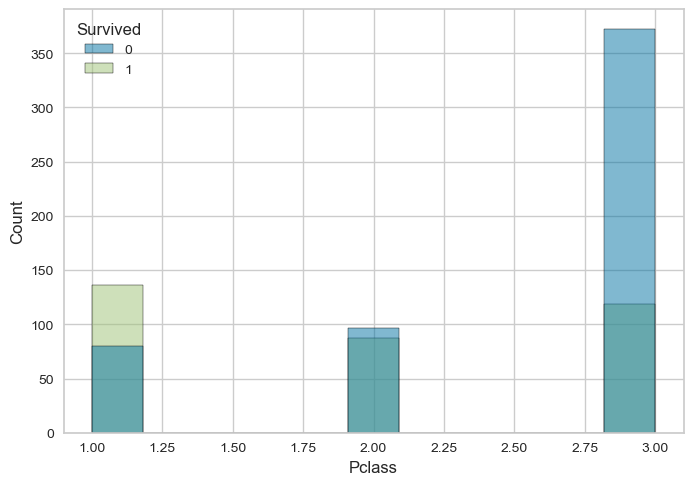

In [166]:
sns.histplot(x = training.Pclass,hue = training.Survived)

In [167]:
#At first sight it looks like, talking in percentages, the rate of survival descends as the class onboard descends.

#### Name

In [168]:
#Lets see if there are any duplicates
titanic.Name.value_counts().max()

2

In [169]:
titanic.Name.value_counts()

Name
Connolly, Miss. Kate                                   2
Kelly, Mr. James                                       2
Braund, Mr. Owen Harris                                1
Johnson, Master. Harold Theodor                        1
Gustafsson, Mr. Alfred Ossian                          1
                                                      ..
Carter, Miss. Lucile Polk                              1
Silvey, Mr. William Baird                              1
Kallio, Mr. Nikolai Erland                             1
Louch, Mrs. Charles Alexander (Alice Adelaide Slow)    1
Peter, Master. Michael J                               1
Name: count, Length: 1307, dtype: int64

In [170]:
#There are a couple of names which are duplicated, maybe is just coincidence

In [171]:
titanic.loc[titanic.Name == "Connolly, Miss. Kate"]

PassengerId  Survived  Pclass                  Name     Sex   Age  SibSp  \
289          290       1.0       3  Connolly, Miss. Kate  female  22.0      0   
6            898       NaN       3  Connolly, Miss. Kate  female  30.0      0   

     Parch  Ticket    Fare Cabin Embarked  train  
289      0  370373  7.7500   NaN        Q      1  
6        0  330972  7.6292   NaN        Q      0

In [172]:
titanic.loc[titanic.Name == "Kelly, Mr. James"]

PassengerId  Survived  Pclass              Name   Sex   Age  SibSp  \
696          697       0.0       3  Kelly, Mr. James  male  44.0      0   
0            892       NaN       3  Kelly, Mr. James  male  34.5      0   

     Parch  Ticket    Fare Cabin Embarked  train  
696      0  363592  8.0500   NaN        S      1  
0        0  330911  7.8292   NaN        Q      0

In [173]:
#Okay, they are different people, no duplicated rows.

In [174]:
#We are facing an interesting variable, because the surname can be an indicator of socio-economic status, 
#as they can belong to a rich or a poor family and maybe affect to the Survival.

In [175]:
#We are gonna split into surname and name.

In [176]:
titanic["apellido"] = titanic.Name.apply(lambda x: x.split(",")[0])

In [177]:
titanic.apellido.value_counts()

apellido
Andersson    11
Sage         11
Goodwin       8
Asplund       8
Davies        7
             ..
Milling       1
Maisner       1
Goncalves     1
Campbell      1
Saether       1
Name: count, Length: 875, dtype: int64

In [178]:
#There are some surnames that are repeated, maybe family members, lets see if there is any kind of correlation

In [179]:
titanic.groupby("Survived")["apellido"].value_counts()

Survived  apellido 
0.0       Andersson    7
          Sage         7
          Panula       6
          Goodwin      6
          Skoog        6
                      ..
1.0       Madigan      1
          Madill       1
          Madsen       1
          Maioni       1
          de Mulder    1
Name: count, Length: 723, dtype: int64

<Axes: xlabel='apellido', ylabel='Count'>

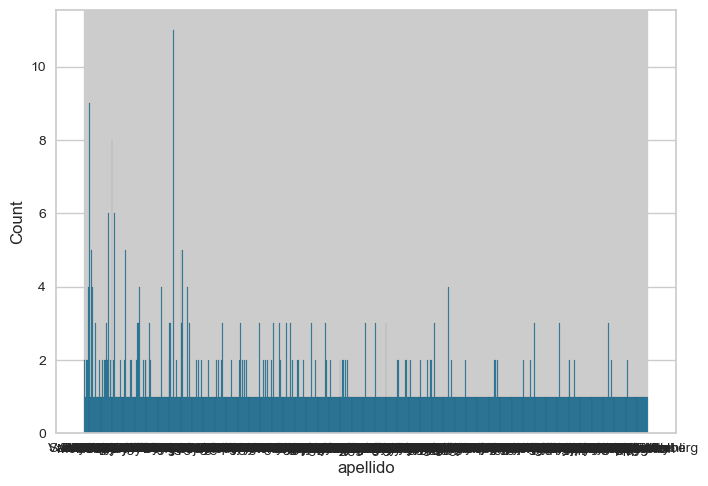

In [180]:
#Lets plot the ones that doesnt survive
sns.histplot(titanic.loc[training["Survived"] == 0,"apellido"])

<Axes: xlabel='apellido', ylabel='Count'>

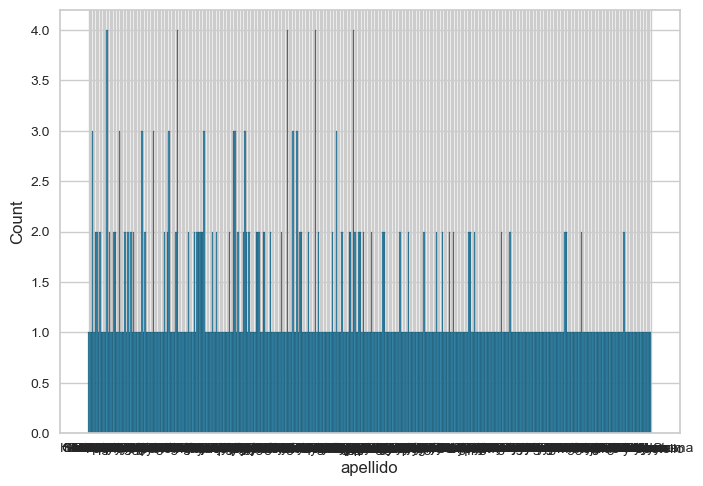

In [181]:
#Lets plot the ones that survive
sns.histplot(titanic.loc[training["Survived"] == 1,"apellido"])

In [182]:
#Maybe is a coincidence, but it looks like the more repeated is the surname, the more chances to not survive, lets see in depth

In [183]:
#Without doubt it is a category variable, but there are too many, lets change it to numeric and analyze it in frequency.

In [184]:
titanic.groupby("apellido")["Survived"].value_counts().sort_values(ascending = False).head(20).unstack()

Survived       0.0  1.0
apellido               
Andersson      7.0  NaN
Sage           7.0  NaN
Panula         6.0  NaN
Goodwin        6.0  NaN
Skoog          6.0  NaN
Rice           5.0  NaN
Carter         NaN  4.0
Baclini        NaN  4.0
Lefebre        4.0  NaN
Palsson        4.0  NaN
Ford           4.0  NaN
Gustafsson     4.0  NaN
Johnson        3.0  3.0
Vander Planke  3.0  NaN
Asplund        NaN  3.0
Johansson      3.0  NaN
Hansen         3.0  NaN
Williams       3.0  NaN
Richards       NaN  3.0

In [185]:
#Its important to know that we are adding a "leyenda", to dont miss information and interpretability
cont = 0
leyenda_apellido = {}
for i in titanic["apellido"]:
    if type(i) == str:
        titanic["apellido"].replace(i,cont,inplace = True)
        leyenda_apellido[i] = cont
        cont += 1

In [186]:
titanic.groupby("apellido")["Survived"].value_counts().sort_values(ascending = False).head(20).unstack()

Survived  0.0  1.0
apellido          
13        7.0  NaN
144       7.0  NaN
61        6.0  NaN
57        6.0  NaN
48        6.0  NaN
16        5.0  NaN
99        4.0  NaN
157       4.0  NaN
82        4.0  NaN
369       NaN  4.0
7         4.0  NaN
218       NaN  4.0
167       3.0  NaN
24        NaN  3.0
338       NaN  3.0
140       3.0  NaN
155       3.0  NaN
18        3.0  NaN
128       3.0  NaN
262       NaN  3.0

In [187]:
leyenda_apellido

{'Braund': 0,
 'Cumings': 1,
 'Heikkinen': 2,
 'Futrelle': 3,
 'Allen': 4,
 'Moran': 5,
 'McCarthy': 6,
 'Palsson': 7,
 'Johnson': 8,
 'Nasser': 9,
 'Sandstrom': 10,
 'Bonnell': 11,
 'Saundercock': 12,
 'Andersson': 13,
 'Vestrom': 14,
 'Hewlett': 15,
 'Rice': 16,
 'Williams': 17,
 'Vander Planke': 18,
 'Masselmani': 19,
 'Fynney': 20,
 'Beesley': 21,
 'McGowan': 22,
 'Sloper': 23,
 'Asplund': 24,
 'Emir': 25,
 'Fortune': 26,
 "O'Dwyer": 27,
 'Todoroff': 28,
 'Uruchurtu': 29,
 'Spencer': 30,
 'Glynn': 31,
 'Wheadon': 32,
 'Meyer': 33,
 'Holverson': 34,
 'Mamee': 35,
 'Cann': 36,
 'Nicola-Yarred': 37,
 'Ahlin': 38,
 'Turpin': 39,
 'Kraeff': 40,
 'Laroche': 41,
 'Devaney': 42,
 'Rogers': 43,
 'Lennon': 44,
 "O'Driscoll": 45,
 'Samaan': 46,
 'Arnold-Franchi': 47,
 'Panula': 48,
 'Nosworthy': 49,
 'Harper': 50,
 'Faunthorpe': 51,
 'Ostby': 52,
 'Woolner': 53,
 'Rugg': 54,
 'Novel': 55,
 'West': 56,
 'Goodwin': 57,
 'Sirayanian': 58,
 'Icard': 59,
 'Harris': 60,
 'Skoog': 61,
 'Stewart': 62

In [188]:
#It looks like an interesting category, it seems that if the surnames are Andersson, Sage, Panula, Goodwin, Skoog or Rice all die.

In [189]:
#Lets make the same with the names

In [190]:
titanic["nombre"] = titanic.Name.apply(lambda x: x.split(",")[1])

In [191]:
titanic.groupby("nombre")["Survived"].value_counts().sort_values(ascending = False).head(20).unstack()

Survived                0.0  1.0
nombre                          
 Mr. John               7.0  NaN
 Mr. James              7.0  NaN
 Mr. William            6.0  NaN
 Miss. Bertha           NaN  4.0
 Mr. William Henry      3.0  NaN
 Mr. Tannous            3.0  NaN
 Miss. Anna Sofia       NaN  3.0
 Mr. William John       3.0  NaN
 Miss. Anna             NaN  3.0
 Mr. Patrick            3.0  NaN
 Miss. Mary             3.0  3.0
 Mr. Samuel             3.0  NaN
 Mr. Martin             3.0  NaN
 Mr. Ivan               3.0  NaN
 Mr. Victor             3.0  NaN
 Mr. Frederick          2.0  NaN
 Mr. Benjamin           2.0  NaN
 Mr. Frederick William  2.0  NaN
 Mr. George             2.0  NaN

In [192]:
#There are also some repeated names that all die or survive, I don't honestly think it has any correlation with survive,
#but lets keep the variable and change it to numeric, as we did with the surname.

In [193]:
cont = 0
leyenda_nombre = {}
for i in titanic["nombre"]:
    if type(i) == str:
        titanic["nombre"].replace(i,cont,inplace = True)
        leyenda_nombre[i] = cont
        cont += 1

#### Sex

In [194]:
#Maybe the most important category, lets plot it

<Axes: xlabel='Sex', ylabel='Count'>

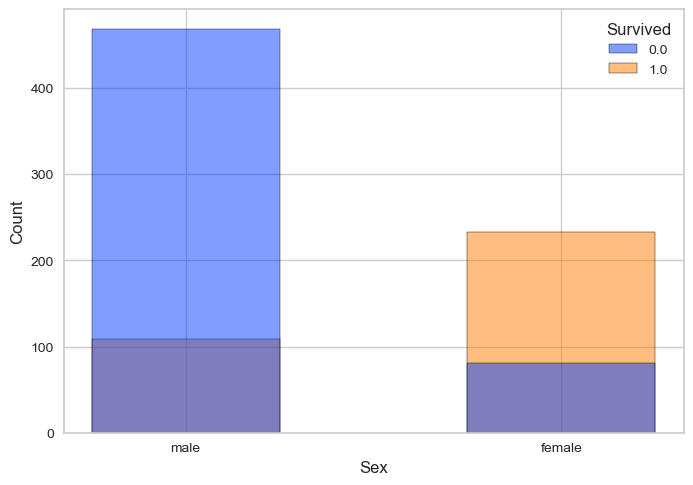

In [195]:
sns.histplot(data = titanic, x = "Sex",shrink = .5,hue = "Survived",palette = "bright")

In [196]:
#There were more men tan women in Titanic and it looks like women survived a lot more, lets try to find why.

In [197]:
#We are going to compare the Class with the Sex and if they survived.

<Axes: xlabel='Pclass,Sex'>

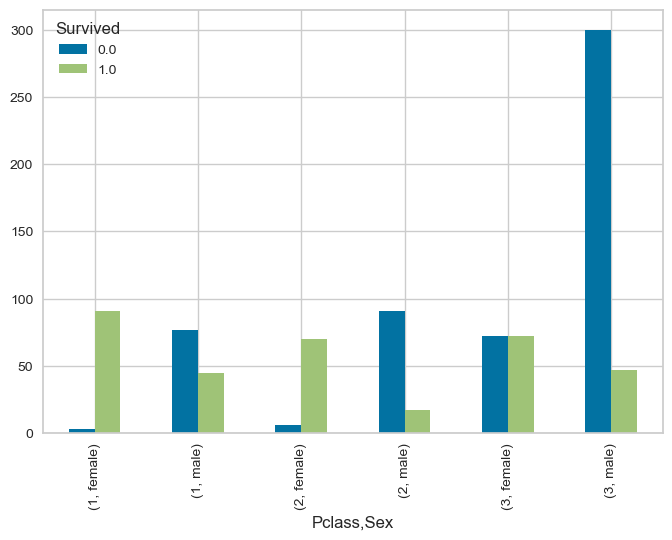

In [198]:
titanic.groupby(["Pclass","Sex"])["Survived"].value_counts().sort_values(ascending = False).unstack().plot(kind= "bar")

In [199]:
#This graphic is really interesting, it looks like almost all women at 1st and 2nd class survived, at 3rd class the rate is 
#more or less 50%.
#Talking about men, the mayority took the 3rd class ticket and died.
#In proportions we can observe how the survival rate descends as the Pclass descends.
#It seems that Pclass + Ticket + Sex can be very usefull predictors

#### Age

In [200]:
#First we need to determine if there are any outliers or non valid values.

In [201]:
titanic.Age.isna().value_counts()

Age
False    1046
True      263
Name: count, dtype: int64

<Axes: xlabel='Age', ylabel='Count'>

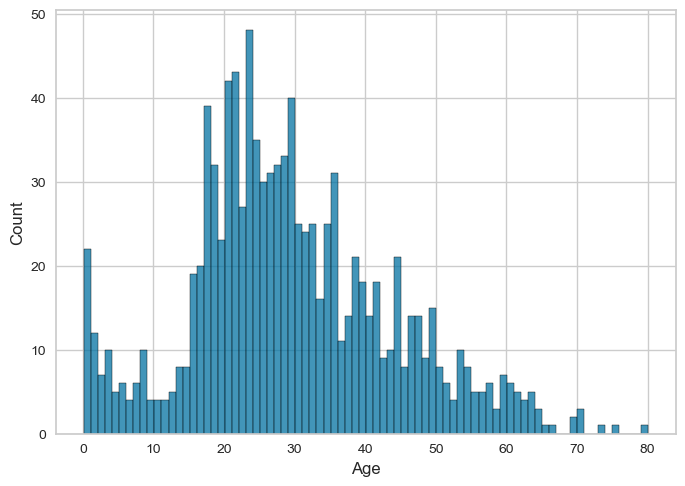

In [202]:
sns.histplot(titanic.Age,bins = 80)

In [203]:
#There arent any values under 0 and the max is 80. Appart from that the curve looks fine for an age variable.
#It is a little left skewed.
#There are some Nans that will be needed to solve. 

In [204]:
#Lets explore more this variable, lets see if the Pclass has any correlation with the Age, like for example, younger people
#buying less expensive class tickets.

<Axes: xlabel='Pclass'>

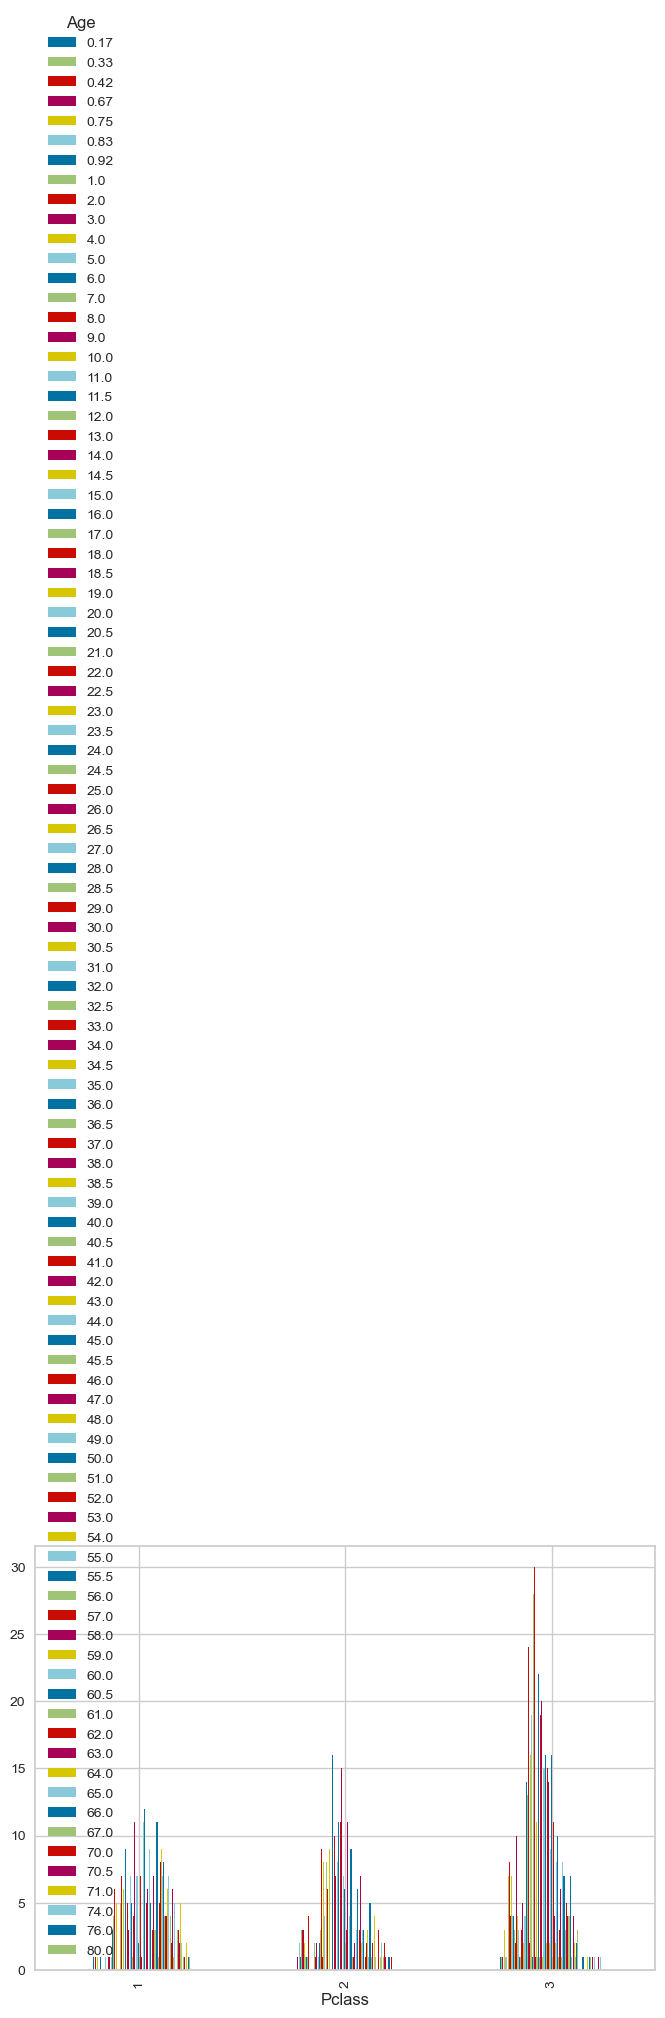

In [205]:
titanic.groupby(["Pclass"])["Age"].value_counts().sort_values(ascending = False).unstack().plot(kind= "bar")

In [206]:
#Its kinda difficult to see here, the graphics seems to follow a Normal distribution, kinda leptokurtic. This is normal as 
#we saw in the previous graphic that adults from 18 to 35 are the most frequent age, ergo they will be the most represented
#in graphics.
#Appart from that is not vissible any correlation between the age of the passenger and the Pclass bought. Maybe the first class
#its a little more mesokurtic than the others, meaning that people from more ages bought that Pclass ticket, but not very clear

#### SibSp

In [207]:
#This variables is # of siblings / spouses aboard the Titanic

In [208]:
titanic.SibSp.value_counts()

SibSp
0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: count, dtype: int64

In [209]:
#This variable is a category, lets change it

In [210]:
titanic.SibSp = titanic.SibSp.astype("category")

In [211]:
titanic.SibSp

0      1
1      1
2      0
3      1
4      0
      ..
413    0
414    0
415    0
416    0
417    1
Name: SibSp, Length: 1309, dtype: category
Categories (7, int64): [0, 1, 2, 3, 4, 5, 8]

<Axes: xlabel='SibSp', ylabel='Count'>

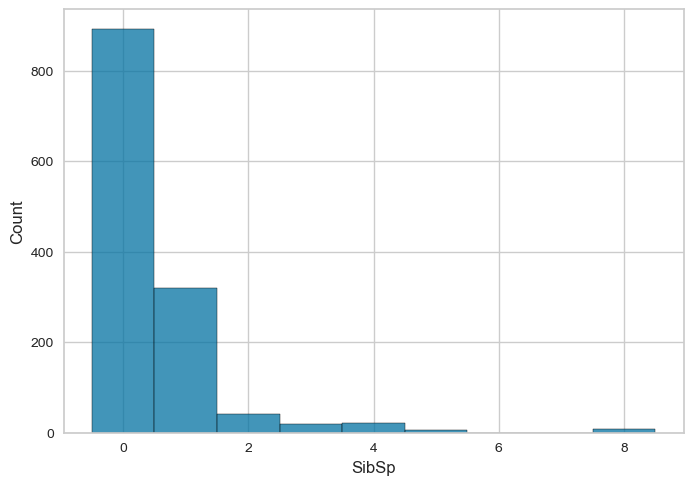

In [212]:
sns.histplot(titanic.SibSp)

In [213]:
#It seems that 0 and 1 have lot of representation, this can add difficulty to the model when working with other classes
#It can be a good idea to group them, for example three groups, 0, 1 and 2, and more than 2.

In [214]:
#Lets see if it could have any correlation with Survived

<Axes: xlabel='SibSp'>

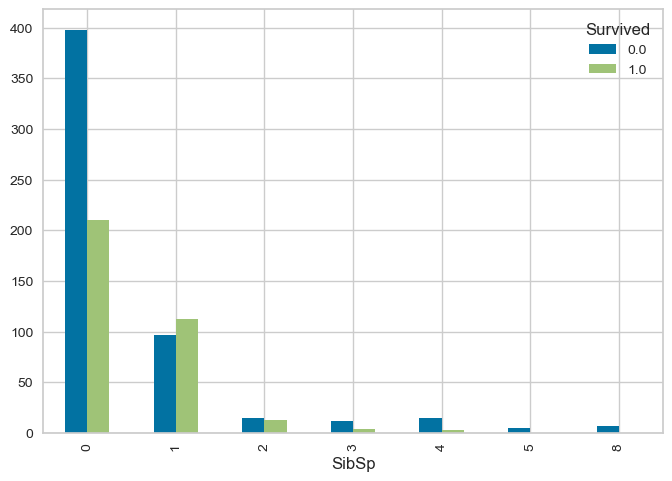

In [215]:
titanic.groupby("SibSp")["Survived"].value_counts().sort_values(ascending = False).unstack().plot(kind= "bar")

In [216]:
#It looks like more than 2 siblings/spouses descends the chances of survival

#### Parch

In [217]:
#This variable talks about # of parents / children aboard the Titanic

In [218]:
titanic.Parch.value_counts()

Parch
0    1002
1     170
2     113
3       8
5       6
4       6
6       2
9       2
Name: count, dtype: int64

In [219]:
#We change it into category aswell.

In [220]:
titanic.Parch = titanic.Parch.astype("category")

In [221]:
#Lets analyze it the same way we did with SibSp

<Axes: xlabel='Parch'>

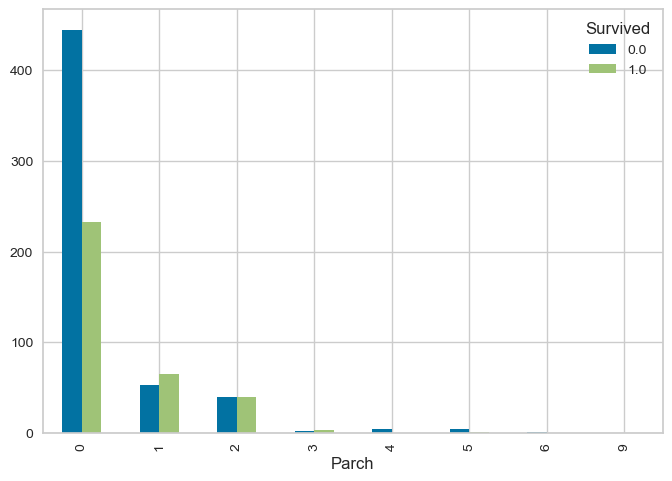

In [222]:
titanic.groupby("Parch")["Survived"].value_counts().sort_values(ascending = False).unstack().plot(kind= "bar")

In [223]:
#Here 0,1 and 2 has more representation, maybe its possible to group them also.

#### Ticket

In [224]:
titanic.Ticket.value_counts().head(20)

Ticket
CA. 2343        11
CA 2144          8
1601             8
PC 17608         7
S.O.C. 14879     7
347077           7
347082           7
3101295          7
19950            6
113781           6
347088           6
382652           6
4133             5
W./C. 6608       5
PC 17757         5
349909           5
220845           5
113503           5
16966            5
LINE             4
Name: count, dtype: int64

In [225]:
#As it is a variable that has numbers and letters, lets see if could find any relation

In [226]:
titanic.loc[titanic.Ticket.str.contains("CA")]

PassengerId  Survived  Pclass  \
59            60       0.0       3   
71            72       0.0       3   
159          160       0.0       3   
180          181       0.0       3   
201          202       0.0       3   
324          325       0.0       3   
386          387       0.0       3   
480          481       0.0       3   
649          650       1.0       3   
678          679       0.0       3   
683          684       0.0       3   
792          793       0.0       3   
846          847       0.0       3   
863          864       0.0       3   
139         1031       NaN       3   
140         1032       NaN       3   
188         1080       NaN       3   
278         1170       NaN       2   
342         1234       NaN       3   
360         1252       NaN       3   
362         1254       NaN       2   
365         1257       NaN       3   

                                             Name     Sex   Age SibSp Parch  \
59             Goodwin, Master. William Frederick    male  11.0     5     2   
71                     Goodwin, Miss. Lillian Amy  female  16.0     5     2   
159                    Sage, Master. Thomas Henry    male   NaN     8     2   
180                  Sage, Miss. Constance Gladys  female   NaN     8     2   
201                           Sage, Mr. Frederick    male   NaN     8     2   
324                      Sage, Mr. George John Jr    male   NaN     8     2   
386               Goodwin, Master. Sidney Leonard    male   1.0     5     2   
480                Goodwin, Master. Harold Victor    male   9.0     5     2   
649               Stanley, Miss. Amy Zillah Elsie  female  23.0     0     0   
678       Goodwin, Mrs. Frederick (Augusta Tyler)  female  43.0     1     6   
683                   Goodwin, Mr. Charles Edward    male  14.0     5     2   
792                       Sage, Miss. Stella Anna  female   NaN     8     2   
846                      Sage, Mr. Douglas Bullen    male   NaN     8     2   
863             Sage, Miss. Dorothy Edith "Dolly"  female   NaN     8     2   
139                Goodwin, Mr. Charles Frederick    male  40.0     1     6   
140                   Goodwin, Miss. Jessie Allis  female  10.0     5     2   
188                               Sage, Miss. Ada  female   NaN     8     2   
278                          Ware, Mr. John James    male  30.0     1     0   
342                         Sage, Mr. John George    male   NaN     1     9   
360                   Sage, Master. William Henry    male  14.5     8     2   
362  Ware, Mrs. John James (Florence Louise Long)  female  31.0     0     0   
365                Sage, Mrs. John (Annie Bullen)  female   NaN     1     9   

       Ticket   Fare Cabin Embarked  train  apellido  nombre  
59    CA 2144  46.90   NaN        S      1        57      58  
71    CA 2144  46.90   NaN        S      1        57      70  
159  CA. 2343  69.55   NaN        S      1       144     156  
180  CA. 2343  69.55   NaN        S      1       144     176  
201  CA. 2343  69.55   NaN        S      1       144     197  
324  CA. 2343  69.55   NaN        S      1       144     310  
386   CA 2144  46.90   NaN        S      1        57     368  
480   CA 2144  46.90   NaN        S      1        57     450  
649  CA. 2314   7.55   NaN        S      1       405     593  
678   CA 2144  46.90   NaN        S      1        57     619  
683   CA 2144  46.90   NaN        S      1        57     624  
792  CA. 2343  69.55   NaN        S      1       144     714  
846  CA. 2343  69.55   NaN        S      1       144     761  
863  CA. 2343  69.55   NaN        S      1       144     777  
139   CA 2144  46.90   NaN        S      0        57     919  
140   CA 2144  46.90   NaN        S      0        57     920  
188  CA. 2343  69.55   NaN        S      0       144     958  
278  CA 31352  21.00   NaN        S      0       818     933  
342  CA. 2343  69.55   NaN        S      0       144    1083  
360  CA. 2343  69.55   NaN        S      0       144

In [227]:
titanic.loc[titanic.Ticket.str.contains("PC")].head(60)

PassengerId  Survived  Pclass  \
1              2       1.0       1   
30            31       0.0       1   
31            32       1.0       1   
34            35       0.0       1   
52            53       1.0       1   
64            65       0.0       1   
96            97       0.0       1   
97            98       1.0       1   
118          119       0.0       1   
139          140       0.0       1   
155          156       0.0       1   
168          169       0.0       1   
177          178       0.0       1   
194          195       1.0       1   
195          196       1.0       1   
256          257       1.0       1   
258          259       1.0       1   
268          269       1.0       1   
269          270       1.0       1   
273          274       0.0       1   
295          296       0.0       1   
299          300       1.0       1   
307          308       1.0       1   
309          310       1.0       1   
311          312       1.0       1   
325          326       1.0       1   
332          333       0.0       1   
334          335       1.0       1   
369          370       1.0       1   
373          374       0.0       1   
375          376       1.0       1   
380          381       1.0       1   
493          494       0.0       1   
505          506       0.0       1   
512          513       1.0       1   
513          514       1.0       1   
527          528       0.0       1   
537          538       1.0       1   
544          545       0.0       1   
557          558       0.0       1   
572          573       1.0       1   
599          600       1.0       1   
609          610       1.0       1   
641          642       1.0       1   
645          646       1.0       1   
660          661       1.0       1   
679          680       1.0       1   
681          682       1.0       1   
700          701       1.0       1   
701          702       1.0       1   
707          708       1.0       1   
710          711       1.0       1   
716          717       1.0       1   
737          738       1.0       1   
742          743       1.0       1   
789          790       0.0       1   
793          794       0.0       1   
835          836       1.0       1   
853          854       1.0       1   
867          868       0.0       1   

                                                  Name     Sex   Age SibSp  \
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0     1   
30                            Uruchurtu, Don. Manuel E    male  40.0     0   
31      Spencer, Mrs. William Augustus (Marie Eugenie)  female   NaN     1   
34                             Meyer, Mr. Edgar Joseph    male  28.0     1   
52            Harper, Mrs. Henry Sleeper (Myna Haxtun)  female  49.0     1   
64                               Stewart, Mr. Albert A    male   NaN     0   
96                           Goldschmidt, Mr. George B    male  71.0     0   
97                     Greenfield, Mr. William Bertram    male  23.0     0   
118                           Baxter, Mr. Quigg Edmond    male  24.0     0   
139                                 Giglio, Mr. Victor    male  24.0     0   
155                        Williams, Mr. Charles Duane    male  51.0     0   
168                                Baumann, Mr. John D    male   NaN     0   
177                         Isham, Miss. Ann Elizabeth  female  50.0     0   
194          Brown, Mrs. James Joseph (Margaret Tobin)  female  44.0     0   
195                               Lurette, Miss. Elise  female  58.0     0   
256                     Thorne, Mrs. Gertrude Maybelle  female   NaN     0   
258                                   Ward, Miss. Anna  female  35.0     0   
268      Graham, Mrs. William Thompson (Edith Junkins)  female  58.0     0   
269                             Bissette, Miss. Amelia  female  35.0     0   
273                              Natsch, Mr. Charles H    male  37.0     0   
295                                  Lewy, Mr. E

In [228]:
titanic.loc[titanic.Ticket.str.contains("PC")].tail(60)

PassengerId  Survived  Pclass  \
493          494       0.0       1   
505          506       0.0       1   
512          513       1.0       1   
513          514       1.0       1   
527          528       0.0       1   
537          538       1.0       1   
544          545       0.0       1   
557          558       0.0       1   
572          573       1.0       1   
599          600       1.0       1   
609          610       1.0       1   
641          642       1.0       1   
645          646       1.0       1   
660          661       1.0       1   
679          680       1.0       1   
681          682       1.0       1   
700          701       1.0       1   
701          702       1.0       1   
707          708       1.0       1   
710          711       1.0       1   
716          717       1.0       1   
737          738       1.0       1   
742          743       1.0       1   
789          790       0.0       1   
793          794       0.0       1   
835          836       1.0       1   
853          854       1.0       1   
867          868       0.0       1   
20           912       NaN       1   
22           914       NaN       1   
23           915       NaN       1   
24           916       NaN       1   
46           938       NaN       1   
59           951       NaN       1   
64           956       NaN       1   
73           965       NaN       1   
81           973       NaN       1   
112         1004       NaN       1   
114         1006       NaN       1   
142         1034       NaN       1   
156         1048       NaN       1   
166         1058       NaN       1   
179         1071       NaN       1   
181         1073       NaN       1   
184         1076       NaN       1   
202         1094       NaN       1   
208         1100       NaN       1   
224         1116       NaN       1   
234         1126       NaN       1   
239         1131       NaN       1   
290         1182       NaN       1   
314         1206       NaN       1   
316         1208       NaN       1   
327         1219       NaN       1   
331         1223       NaN       1   
343         1235       NaN       1   
350         1242       NaN       1   
375         1267       NaN       1   
391         1283       NaN       1   
414         1306       NaN       1   

                                                  Name     Sex   Age SibSp  \
493                            Artagaveytia, Mr. Ramon    male  71.0     0   
505         Penasco y Castellana, Mr. Victor de Satode    male  18.0     1   
512                          McGough, Mr. James Robert    male  36.0     0   
513     Rothschild, Mrs. Martin (Elizabeth L. Barrett)  female  54.0     1   
527                                 Farthing, Mr. John    male   NaN     0   
537                                LeRoy, Miss. Bertha  female  30.0     0   
544                         Douglas, Mr. Walter Donald    male  50.0     1   
557                                Robbins, Mr. Victor    male   NaN     0   
572                   Flynn, Mr. John Irwin ("Irving")    male  36.0     0   
599       Duff Gordon, Sir. Cosmo Edmund ("Mr Morgan")    male  49.0     1   
609                          Shutes, Miss. Elizabeth W  female  40.0     0   
641                               Sagesser, Mlle. Emma  female  24.0     0   
645                          Harper, Mr. Henry Sleeper    male  48.0     1   
660                      Frauenthal, Dr. Henry William    male  50.0     2   
679                 Cardeza, Mr. Thomas Drake Martinez    male  36.0     0   
681                                 Hassab, Mr. Hammad    male  27.0     0   
700  Astor, Mrs. John Jacob (Madeleine Talmadge Force)  female  18.0     1   
701                   Silverthorne, Mr. Spencer Victor    male  35.0     0   
707                  Calderhead, Mr. Edward Pennington    male  42.0     0   
710   Mayne, Mlle. Berthe Antonine ("Mrs de Villiers")  female  24.0     0   
716                      Endres, Miss. Caroline 

In [229]:
titanic.loc[titanic.Ticket.str.contains("S.O.C")]

PassengerId  Survived  Pclass                         Name   Sex   Age  \
72            73       0.0       2         Hood, Mr. Ambrose Jr  male  21.0   
120          121       0.0       2  Hickman, Mr. Stanley George  male  21.0   
385          386       0.0       2    Davies, Mr. Charles Henry  male  18.0   
655          656       0.0       2    Hickman, Mr. Leonard Mark  male  24.0   
665          666       0.0       2           Hickman, Mr. Lewis  male  32.0   
212         1104       NaN       2    Deacon, Mr. Percy William  male  17.0   
352         1244       NaN       2          Dibden, Mr. William  male  18.0   

    SibSp Parch        Ticket  Fare Cabin Embarked  train  apellido  nombre  
72      0     0  S.O.C. 14879  73.5   NaN        S      1        68      71  
120     2     0  S.O.C. 14879  73.5   NaN        S      1       112     117  
385     0     0  S.O.C. 14879  73.5   NaN        S      1       325     367  
655     2     0  S.O.C. 14879  73.5   NaN        S      1       112     598  
665     2     0  S.O.C. 14879  73.5   NaN        S      1       112     607  
212     0     0  S.O.C. 14879  73.5   NaN        S      0       786     979  
352     0     0  S.O.C. 14879  73.5   NaN        S      0       847     187

In [230]:
titanic.loc[titanic.Ticket.str.contains("W./C.")]

PassengerId  Survived  Pclass  \
86            87       0.0       3   
147          148       0.0       3   
235          236       0.0       3   
242          243       0.0       2   
436          437       0.0       3   
526          527       1.0       2   
736          737       0.0       3   
783          784       0.0       3   
888          889       0.0       3   
33           925       NaN       3   
167         1059       NaN       3   
222         1114       NaN       2   
244         1136       NaN       3   
279         1171       NaN       2   

                                                  Name     Sex   Age SibSp  \
86                              Ford, Mr. William Neal    male  16.0     1   
147                   Ford, Miss. Robina Maggie "Ruby"  female   9.0     2   
235                       Harknett, Miss. Alice Phoebe  female   NaN     0   
242                    Coleridge, Mr. Reginald Charles    male  29.0     0   
436               Ford, Miss. Doolina Margaret "Daisy"  female  21.0     2   
526                               Ridsdale, Miss. Lucy  female  50.0     0   
736            Ford, Mrs. Edward (Margaret Ann Watson)  female  48.0     1   
783                             Johnston, Mr. Andrew G    male   NaN     1   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN     1   
33   Johnston, Mrs. Andrew G (Elizabeth Lily" Watson)"  female   NaN     1   
167                            Ford, Mr. Edward Watson    male  18.0     2   
222                         Cook, Mrs. (Selena Rogers)  female  22.0     0   
244          Johnston, Master. William Arthur Willie""    male   NaN     1   
279                          Oxenham, Mr. Percy Thomas    male  22.0     0   

    Parch       Ticket    Fare Cabin Embarked  train  apellido  nombre  
86      3   W./C. 6608  34.375   NaN        S      1        82      84  
147     2   W./C. 6608  34.375   NaN        S      1        82     144  
235     0   W./C. 6609   7.550   NaN        S      1       206     230  
242     0  W./C. 14263  10.500   NaN        S      1       212     236  
436     2   W./C. 6608  34.375   NaN        S      1        82     411  
526     0  W./C. 14258  10.500   NaN        S      1       431     490  
736     3   W./C. 6608  34.375   NaN        S      1        82     668  
783     2   W./C. 6607  23.450   NaN        S      1       604     709  
888     2   W./C. 6607  23.450   NaN        S      1       604     801  
33      2   W./C. 6607  23.450   NaN        S      0       604     829  
167     2   W./C. 6608  34.375   NaN        S      0        82     940  
222     0  W./C. 14266  10.500   F33        S      0       524     988  
244     2   W./C. 6607  23.450   NaN        S      0       604    1007  
279     0  W./C. 14260  10.500   NaN        S      0       819    1034

In [231]:
titanic.loc[titanic.Ticket.str.contains("347077")]

PassengerId  Survived  Pclass  \
25            26       1.0       3   
182          183       0.0       3   
233          234       1.0       3   
261          262       1.0       3   
154         1046       NaN       3   
174         1066       NaN       3   
379         1271       NaN       3   

                                                  Name     Sex   Age SibSp  \
25   Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...  female  38.0     1   
182              Asplund, Master. Clarence Gustaf Hugo    male   9.0     4   
233                     Asplund, Miss. Lillian Gertrud  female   5.0     4   
261                  Asplund, Master. Edvin Rojj Felix    male   3.0     4   
154                       Asplund, Master. Filip Oscar    male  13.0     4   
174         Asplund, Mr. Carl Oscar Vilhelm Gustafsson    male  40.0     1   
379                        Asplund, Master. Carl Edgar    male   5.0     4   

    Parch  Ticket     Fare Cabin Embarked  train  apellido  nombre  
25      5  347077  31.3875   NaN        S      1        24      24  
182     2  347077  31.3875   NaN        S      1        24     178  
233     2  347077  31.3875   NaN        S      1        24     228  
261     2  347077  31.3875   NaN        S      1        24     254  
154     2  347077  31.3875   NaN        S      0        24     931  
174     5  347077  31.3875   NaN        S      0        24     946  
379     2  347077  31.3875   NaN        S      0        24    1114

In [232]:
#Im not convinced of how could Ticket be grouped, nevertheless i consider it a category, and as there are too many, we convert
#it into numeric.

In [233]:
cont = 0
leyenda_ticket = {}
for i in titanic["Ticket"]:
    if type(i) == str:
        titanic["Ticket"].replace(i,cont,inplace = True)
        leyenda_ticket[i] = cont
        cont += 1

### Fare

In [234]:
#It gives the amount every Passenger paid.

In [235]:
titanic.Fare.value_counts()

Fare
8.0500     60
13.0000    59
7.7500     55
26.0000    50
7.8958     49
           ..
7.7417      1
8.1583      1
8.4583      1
7.8000      1
7.7208      1
Name: count, Length: 281, dtype: int64

In [236]:
#Lets see if there is any correlation between Fare and Age.

<Axes: xlabel='Age', ylabel='Fare'>

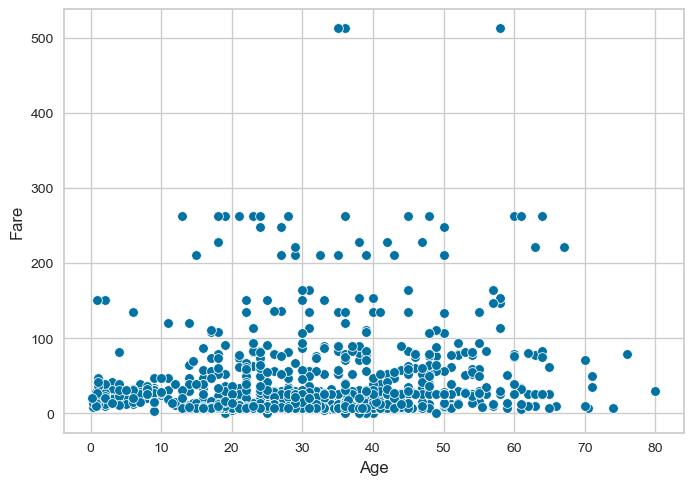

In [237]:
sns.scatterplot(x = titanic.Age, y = titanic.Fare)

In [238]:
#It looks so uniform, no tendences. Lets split it with Survived

<Axes: xlabel='Age', ylabel='Fare'>

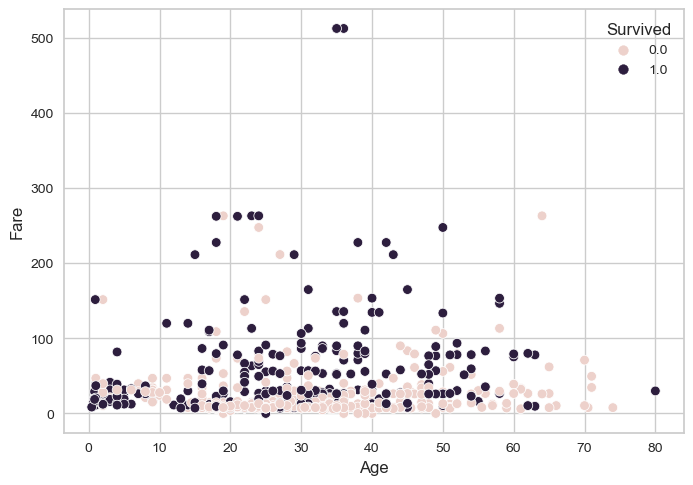

In [239]:
sns.scatterplot(x = titanic.Age, y = titanic.Fare,hue = titanic.Survived)

In [240]:
#Here a little tendence can be observed with Fare in Survival. It looks like generally the people who had bigger Fare survived.
#It has a lot of sense because bigger Fare could mean better PClass ticket, and more survival chances.

In [241]:
#Lets now see who tended to pay more.

<Axes: xlabel='Age', ylabel='Fare'>

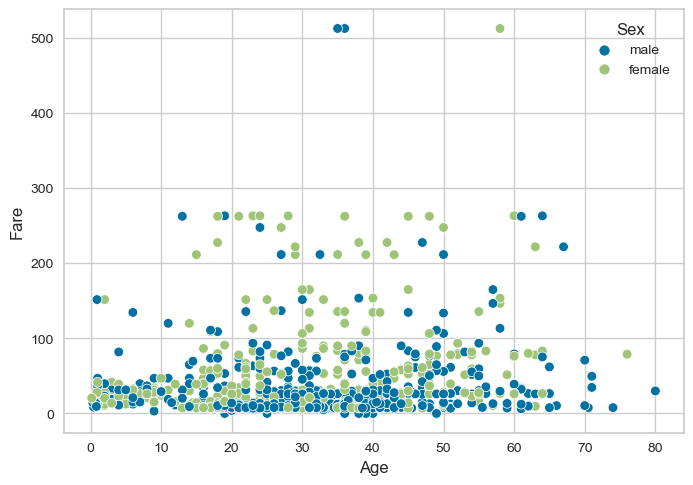

In [242]:
sns.scatterplot(x = titanic.Age, y = titanic.Fare,hue = titanic.Sex)

In [243]:
#It difficult to determine, maybe women tended to pay more. Lets see it more clearly.

<Axes: xlabel='Sex', ylabel='Fare'>

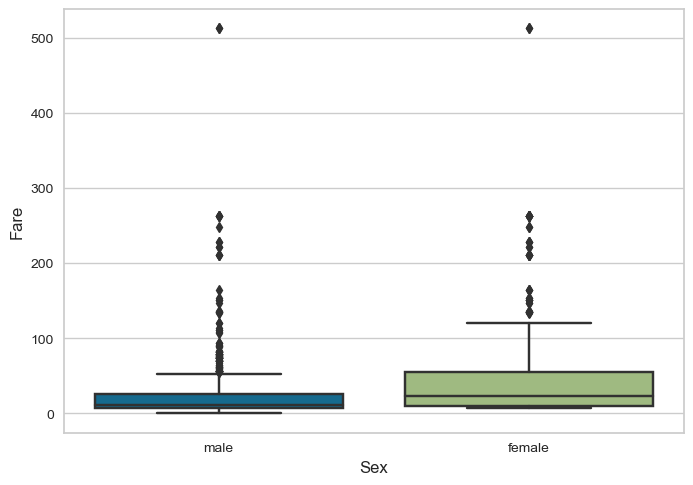

In [244]:
sns.boxplot(x = titanic.Sex,y = titanic.Fare)

In [245]:
#Here it is, women tended generally to pay more.
#Maybe we can theorize that due to the women paying more they had a better ticket and a better position in the Titanic that lead
#them to survive more than men.

In [246]:
#Maybe we can group the Age variable

### Cabin

In [247]:
#Cabin talks about the cabin number

In [248]:
titanic.Cabin.isna().sum()

1014

In [249]:
titanic.Cabin.value_counts().sum()

295

In [250]:
#With this variable we have too much Nans, there are more Nans than values.
#In this situation the variable cant give information, it is better to delete it.

In [251]:
titanic.drop("Cabin",axis = 1,inplace = True)

### Embarked

In [252]:
#Embarked talks about port of embarkation: C = Cherbourg, Q = Queenstown, S = Southampton

In [253]:
titanic.Embarked.value_counts()

Embarked
S    914
C    270
Q    123
Name: count, dtype: int64

In [254]:
#Lets try to find relations with Survived

<Axes: xlabel='Embarked'>

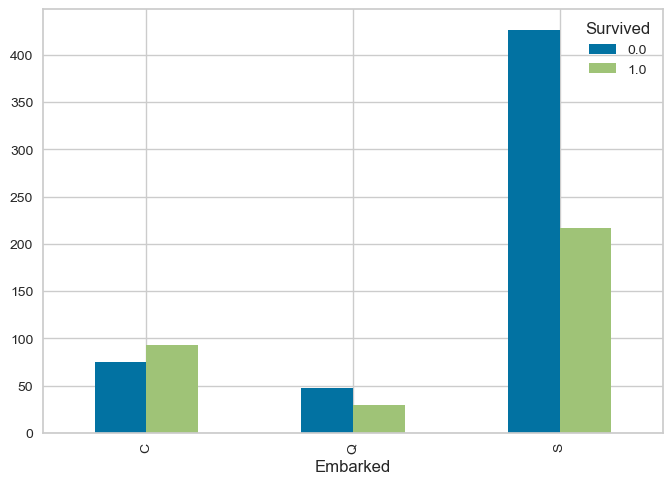

In [255]:
titanic.groupby("Embarked")["Survived"].value_counts().sort_values(ascending = False).unstack().plot(kind= "bar")

In [256]:
#Here we see that the mayority embarked in Southampton. It is curious that the embarked in Cherbourg survived more

In [257]:
#Lets now compare by sex

<Axes: xlabel='Embarked'>

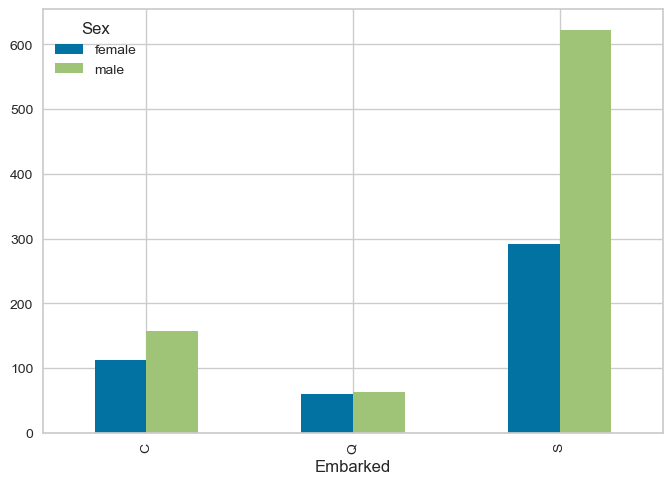

In [258]:
titanic.groupby("Embarked")["Sex"].value_counts().sort_values(ascending = False).unstack().plot(kind= "bar")

In [259]:
#So interesting, in Cherbourg embarked more male than females but has the best proportion of survivals.
#Maybe it has some correlation the port of embarkation with the Pclass, lets plot it.

<Axes: xlabel='Embarked'>

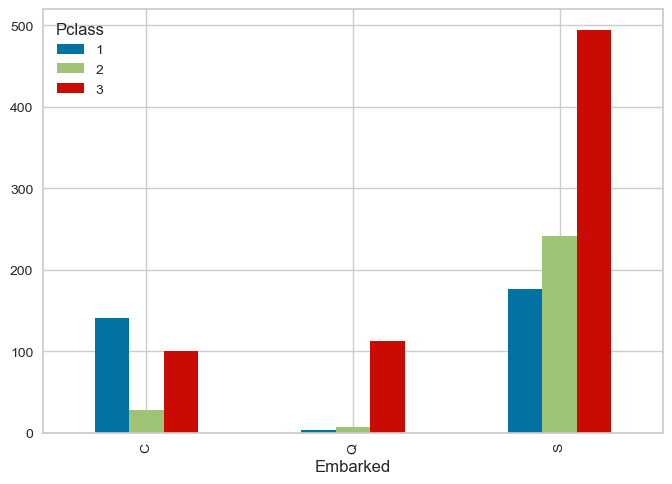

In [260]:
titanic.groupby("Embarked")["Pclass"].value_counts().sort_values(ascending = False).unstack().plot(kind= "bar")

In [261]:
#This graph is so interesting because in Chersbourg the majority of people went in 1st class, that is what explains the survival.
#The most interesting thing is that the people who embarked in Queenstown, despite of almost everyone going in 3rd class, the 
#survival rate is a little lower than 50%, that means that many people that went in 3rd class survived there.

# Step 4 - Data cleaning

In [262]:
#Lets overview the dataset and its dtypes

In [263]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 417
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1309 non-null   int64   
 1   Survived     891 non-null    float64 
 2   Pclass       1309 non-null   int64   
 3   Name         1309 non-null   object  
 4   Sex          1309 non-null   object  
 5   Age          1046 non-null   float64 
 6   SibSp        1309 non-null   category
 7   Parch        1309 non-null   category
 8   Ticket       1309 non-null   int64   
 9   Fare         1308 non-null   float64 
 10  Embarked     1307 non-null   object  
 11  train        1309 non-null   int64   
 12  apellido     1309 non-null   int64   
 13  nombre       1309 non-null   int64   
dtypes: category(2), float64(3), int64(6), object(3)
memory usage: 136.2+ KB


In [264]:
#As we saw earlier, some variables should be categories, lets change them

In [265]:
titanic.Survived = titanic.Survived.astype("category")

In [266]:
titanic.Pclass = titanic.Pclass.astype("category")

In [267]:
titanic.Sex  = titanic.Sex.astype("category")

In [268]:
titanic.Embarked = titanic.Embarked.astype("category")

In [269]:
#Also in Age lets consider as 0 years old the babies who are less than 1 year old.

In [270]:
titanic.loc[titanic.Age < 1,"Age"] = 0

In [271]:
#Now lets see how to solve the nulls

In [272]:
titanic.loc[titanic.train == 1].info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    category
 2   Pclass       891 non-null    category
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    category
 7   Parch        891 non-null    category
 8   Ticket       891 non-null    int64   
 9   Fare         891 non-null    float64 
 10  Embarked     889 non-null    category
 11  train        891 non-null    int64   
 12  apellido     891 non-null    int64   
 13  nombre       891 non-null    int64   
dtypes: category(6), float64(2), int64(5), object(1)
memory usage: 69.1+ KB


In [273]:
#There are 2 columns with Nans, Embarked and Age.

In [274]:
titanic.loc[titanic.Embarked.isna()]

PassengerId Survived Pclass                                       Name  \
61            62      1.0      1                        Icard, Miss. Amelie   
829          830      1.0      1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age SibSp Parch  Ticket  Fare Embarked  train  apellido  nombre  
61   female  38.0     0     0      60  80.0      NaN      1        59      60  
829  female  62.0     0     0      60  80.0      NaN      1       629     746

In [275]:
#Generally 2 rows from 891 aren't important enaugh if we consider to directly delete them, but if we take a closer look we 
#can observe they belong to the Survived, the minority class, and payin low Fare, so we are going to impute them as i consider
#it can bring information.

In [276]:
#The method I choose is to use a filter that brings me similar rows and then impute with the most repeated value

In [277]:
titanic.query("Survived == 1 & Sex == 'female' & Pclass == 1 & Age > 37 & Fare < 81 & Fare >70")

PassengerId Survived Pclass  \
1              2      1.0      1   
52            53      1.0      1   
61            62      1.0      1   
275          276      1.0      1   
366          367      1.0      1   
496          497      1.0      1   
558          559      1.0      1   
591          592      1.0      1   
765          766      1.0      1   
829          830      1.0      1   

                                                  Name     Sex   Age SibSp  \
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0     1   
52            Harper, Mrs. Henry Sleeper (Myna Haxtun)  female  49.0     1   
61                                 Icard, Miss. Amelie  female  38.0     0   
275                  Andrews, Miss. Kornelia Theodosia  female  63.0     1   
366   Warren, Mrs. Frank Manley (Anna Sophia Atkinson)  female  60.0     1   
496                     Eustis, Miss. Elizabeth Mussey  female  54.0     1   
558             Taussig, Mrs. Emil (Tillie Mandelbaum)  female  39.0     1   
591    Stephenson, Mrs. Walter Bertram (Martha Eustis)  female  52.0     1   
765               Hogeboom, Mrs. John C (Anna Andrews)  female  51.0     1   
829          Stone, Mrs. George Nelson (Martha Evelyn)  female  62.0     0   

    Parch  Ticket     Fare Embarked  train  apellido  nombre  
1       0       1  71.2833        C      1         1       1  
52      0      51  76.7292        C      1        50      51  
61      0      60  80.0000      NaN      1        59      60  
275     0     245  77.9583        S      1       240     265  
366     0     316  75.2500        C      1       310     351  
496     0     416  78.2667        C      1       407     465  
558     1     234  79.6500        S      1       228     518  
591     0     416  78.2667        C      1       475     545  
765     0     245  77.9583        S      1       591     692  
829     0      60  80.0000      NaN      1       629     746

In [278]:
#Using that filter that shows the rows under those conditions we can observe that the most probably port of Embarkation is C.

In [279]:
titanic.loc[titanic.Embarked.isna(),"Embarked"] = "C"

In [280]:
#Now lets impute Age

In [281]:
#In this case im gonna split categorical and numerical columns.
#Then im gonna use Iterative imputer on the numeric columns (Age is numeric column)
#Then im gonna join that numeric columns imputed with the categorical columns.
#Lastly Im gonna call that dataset titanic_imputado

In [282]:
imput_cont = titanic.select_dtypes(include=np.number)
categóricas = titanic.select_dtypes(exclude=np.number)
imputer_itImp = skl_imp.IterativeImputer(max_iter=10, random_state=0)
imput_imputed = pd.DataFrame(imputer_itImp.fit_transform(imput_cont),columns=imput_cont.columns)

In [283]:
imput_imputed.reset_index(drop = True,inplace = True)

In [284]:
categóricas.reset_index(drop = True,inplace = True)

In [285]:
titanic_imputado = imput_imputed.join(categóricas)

In [286]:
titanic_imputado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1309 non-null   float64 
 1   Age          1309 non-null   float64 
 2   Ticket       1309 non-null   float64 
 3   Fare         1309 non-null   float64 
 4   train        1309 non-null   float64 
 5   apellido     1309 non-null   float64 
 6   nombre       1309 non-null   float64 
 7   Survived     891 non-null    category
 8   Pclass       1309 non-null   category
 9   Name         1309 non-null   object  
 10  Sex          1309 non-null   category
 11  SibSp        1309 non-null   category
 12  Parch        1309 non-null   category
 13  Embarked     1309 non-null   category
dtypes: category(6), float64(7), object(1)
memory usage: 90.8+ KB


In [287]:
#With this titanic_imputado we dont have any more Nans, except Survived that is normal because we have training and test together

In [288]:
titanic_imputado["train"] = titanic_imputado["train"].astype("category")

In [289]:
#With the iterative imputer it converted the types to floats and there also no round numbers, so we convert it to "int64"
#to also round them

In [290]:
titanic_imputado[["PassengerId","Age","Ticket","Fare","apellido","nombre"]] = titanic_imputado[["PassengerId","Age","Ticket","Fare","apellido","nombre"]].astype("int64")

In [291]:
titanic_imputado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1309 non-null   int64   
 1   Age          1309 non-null   int64   
 2   Ticket       1309 non-null   int64   
 3   Fare         1309 non-null   int64   
 4   train        1309 non-null   category
 5   apellido     1309 non-null   int64   
 6   nombre       1309 non-null   int64   
 7   Survived     891 non-null    category
 8   Pclass       1309 non-null   category
 9   Name         1309 non-null   object  
 10  Sex          1309 non-null   category
 11  SibSp        1309 non-null   category
 12  Parch        1309 non-null   category
 13  Embarked     1309 non-null   category
dtypes: category(7), int64(6), object(1)
memory usage: 82.0+ KB


# Step 5 - First model approach

In [292]:
#We are going to make our first submission using Pycaret, just as a first approach

In [293]:
#As we said, lets try Pycaret with all variables, except Name, because we added nombre and apellido
#We will use the dataset with Nans to see how Pycaret solve it.

In [294]:
modelo_competicion(tipo = "pycaret",data = titanic,Id = "PassengerId",objetivo = "Survived",exclude = "Name",save = "pycaret_titanic")

Se utilizarán las siguientes variables Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked',
       'apellido', 'nombre'],
      dtype='object')
Se va a predecir la siguiente variable Survived


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

Prediccion exitosa
Se ha guardado el archivo exitosamente como: pycaret_titanic.csv


"Introduzca un tipo valido: 'pycaret','rf','lr','lightgbm'"

In [295]:
#Interesting to see that Pycaret chooses a gradient boosting classifier as the best option.

In [296]:
#It gave score: 0,74641

In [297]:
#Now lets make the same but with the imputed dataset.

In [298]:
modelo_competicion(tipo = "pycaret",data = titanic_imputado,Id = "PassengerId",objetivo = "Survived",exclude = "Name",save = "pycaret_imputado")

Se utilizarán las siguientes variables Index(['Age', 'Ticket', 'Fare', 'apellido', 'nombre', 'Pclass', 'Sex', 'SibSp',
       'Parch', 'Embarked'],
      dtype='object')
Se va a predecir la siguiente variable Survived


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

Prediccion exitosa
Se ha guardado el archivo exitosamente como: pycaret_imputado.csv


"Introduzca un tipo valido: 'pycaret','rf','lr','lightgbm'"

In [299]:
#Gradient boosting classifier remains as the best option but now Lightgbm is the second best one.

In [300]:
#This submission scores 0,74641, the same, so Pycaret doesnt mind if the dataset is imputed or not.

# Step 6 - Comparison and improvement of models

In [301]:
#We chose Random Forest, Linear Regression and Lightgbm as the models for this competition.

## Step 6.1 - Model comparison - Original dataset

In [302]:
#As first approach we are going to use the dataset with Nans

In [303]:
#Lets start with random forest

In [304]:
modelo_competicion(tipo = "rf",data = titanic,Id = "PassengerId",objetivo = "Survived",exclude = "Name",save = "rf1_titanic")

Se utilizarán las siguientes variables Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked',
       'apellido', 'nombre'],
      dtype='object')
Se va a predecir la siguiente variable Survived
Accuracy en training: 1.0
[[95 15]
 [21 48]]
              precision    recall  f1-score   support

         0.0       0.82      0.86      0.84       110
         1.0       0.76      0.70      0.73        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179

Se ha guardado el archivo exitosamente como: rf1_titanic.csv


In [305]:
#It scored 0,77033, better than Pycaret, lets try lightgbm.
#Its important to see how the metrics and the confussion matrix has issues identifying the 1, the ones that survived.
#That is because of the sample size. Many more people not survived than the ones that survived.

In [306]:
modelo_competicion(tipo = "lightgbm",data = titanic,Id = "PassengerId",objetivo = "Survived",exclude = "Name",save = "lightgbm_titanic")

Se utilizarán las siguientes variables Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked',
       'apellido', 'nombre'],
      dtype='object')
Se va a predecir la siguiente variable Survived
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 922
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [307]:
#It scored 0,75358, worst than Random Forest

In [308]:
#LogisticRegression cant be used with Nans.

## Step 6.2 - Model comparison - Imputed dataset

In [309]:
#The dataset will be titanic_imputado, excluding "Name" as before.

In [310]:
modelo_competicion(tipo = "rf",data = titanic_imputado,Id = "PassengerId",objetivo = "Survived",exclude = "Name",save = "rf1_imputado")

Se utilizarán las siguientes variables Index(['Age', 'Ticket', 'Fare', 'apellido', 'nombre', 'Pclass', 'Sex', 'SibSp',
       'Parch', 'Embarked'],
      dtype='object')
Se va a predecir la siguiente variable Survived
Accuracy en training: 1.0
[[97 13]
 [23 46]]
              precision    recall  f1-score   support

         0.0       0.81      0.88      0.84       110
         1.0       0.78      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.80      0.80      0.80       179

Se ha guardado el archivo exitosamente como: rf1_imputado.csv


In [311]:
#The score goes down to 0,76315, according to the confussion matrix it identifies better the 0 than the 1 in relation with the
#previous random forest using the dataset with Nans.

In [312]:
modelo_competicion(tipo = "lightgbm",data = titanic_imputado,Id = "PassengerId",objetivo = "Survived",exclude = "Name",save = "lightgbm_imputado")

Se utilizarán las siguientes variables Index(['Age', 'Ticket', 'Fare', 'apellido', 'nombre', 'Pclass', 'Sex', 'SibSp',
       'Parch', 'Embarked'],
      dtype='object')
Se va a predecir la siguiente variable Survived
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [313]:
#This lightgbm scores 0,76794. Better than the previous Lightgbm model and this Random Forest, 
#still worst than the first Random Forest

In [314]:
modelo_competicion(tipo = "lr",data = titanic_imputado,Id = "PassengerId",objetivo = "Survived",exclude = "Name",save = "lr_imputado")

Se utilizarán las siguientes variables Index(['Age', 'Ticket', 'Fare', 'apellido', 'nombre', 'Pclass', 'Sex', 'SibSp',
       'Parch', 'Embarked'],
      dtype='object')
Se va a predecir la siguiente variable Survived
Accuracy en training: 0.8160112359550562
[[96 14]
 [23 46]]
              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84       110
         1.0       0.77      0.67      0.71        69

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.79      0.79      0.79       179

Se ha guardado el archivo exitosamente como: lr_imputado.csv


In [315]:
#Logitic Regression scores 0,75358, the worst of the three models.

## Step 6.3 - Model comparison - Imputed dataset and grouped variables

In [316]:
#In this case we will make the comparison with two differences:
  #Categorical variables will be grouped.
  #Continuous variables will be split and trasnformed into categorical values.
#Everything will be done automatically using BinningProcess
#The criteria will be:
  #Information Value (iv) > 0.02
  #Gini > 0.15

In [317]:
#varObj will be target
varObj = titanic_imputado.loc[titanic_imputado["train"] == 1, "Survived"].copy()
# varPred will be all possible predictor columns.
varPred = titanic_imputado.loc[titanic_imputado["train"] == 1].copy()
varPred.drop(["train", "Id", "PassengerId","Survived"], axis=1, inplace=True)

In [318]:
Y = varObj.values
X = varPred
list_variables = X.columns.values.tolist()
list_categorical = X.select_dtypes(include=['object', 'category']).columns.values.tolist()
selection_criteria = {    "iv": {"min": 0.02} ,    "gini": {"min":0.15}}
binning_fit_params={    "purpose":{"cat_cutoff": 0.10}}
binning_process = BinningProcess(categorical_variables=list_categorical,variable_names=list_variables,selection_criteria=selection_criteria,binning_fit_params=binning_fit_params)
dt_binned = binning_process.fit(X, Y)
dt_binned.summary().sort_values('iv',ascending = False)

name        dtype   status  selected n_bins        iv        js  \
7        Sex  categorical  OPTIMAL      True      2  1.341681  0.156267   
2       Fare    numerical  OPTIMAL      True      6  0.604981  0.070891   
5     Pclass  categorical  OPTIMAL      True      3   0.50095  0.060838   
1     Ticket    numerical  OPTIMAL      True      8  0.193233  0.023382   
8      SibSp  categorical  OPTIMAL      True      3  0.175512  0.021301   
0        Age    numerical  OPTIMAL      True      8  0.140856  0.016775   
10  Embarked  categorical  OPTIMAL      True      3  0.129404  0.015913   
9      Parch  categorical  OPTIMAL     False      3   0.11554  0.014252   
3   apellido    numerical  OPTIMAL     False      6  0.114636  0.013806   
4     nombre    numerical  OPTIMAL     False      6  0.103087  0.012433   
6       Name  categorical  OPTIMAL     False      1       0.0       0.0   

        gini quality_score  
7   0.533746      0.010858  
2   0.395477      0.015411  
5   0.362834      0.695377  
1     0.2181      0.056602  
8   0.190272      0.379064  
0   0.170784      0.000137  
10  0.155072      0.175565  
9   0.145517      0.116523  
3   0.125619         0.001  
4   0.126093      0.003135  
6          0           0.0

In [319]:
#This is so interesting, it dropped Parch, apellido , nombre and Name.
#Lets review them

In [320]:
dt_binned.get_binned_variable("Fare").binning_table.build()

Bin  Count  Count (%)  Non-event  Event  Event rate  \
0         (-inf, 8.50)    311   0.349046        249     62    0.199357   
1        [8.50, 10.50)     53   0.059484         39     14    0.264151   
2       [10.50, 15.50)    120   0.134680         69     51    0.425000   
3       [15.50, 50.50)    248   0.278339        142    106    0.427419   
4       [50.50, 74.00)     62   0.069585         27     35    0.564516   
5         [74.00, inf)     97   0.108866         23     74    0.762887   
6              Special      0   0.000000          0      0    0.000000   
7              Missing      0   0.000000          0      0    0.000000   
Totals                    891   1.000000        549    342    0.383838   

             WoE        IV        JS  
0       0.917031  0.249676  0.030160  
1       0.551217  0.016593  0.002048  
2      -0.171007  0.004008  0.000500  
3        -0.1809  0.009278  0.001158  
4      -0.732799  0.038955  0.004763  
5      -1.641859  0.286471  0.032261  
6            0.0  0.000000  0.000000  
7            0.0  0.000000  0.000000  
Totals            0.604981  0.070891

In [321]:
#As a continuous variable it split it into that categories.

In [322]:
dt_binned.get_binned_variable("Ticket").binning_table.build()

Bin  Count  Count (%)  Non-event  Event  Event rate  \
0         (-inf, 164.50)    271   0.304153        180     91    0.335793   
1       [164.50, 227.50)     81   0.090909         49     32    0.395062   
2       [227.50, 266.50)     62   0.069585         28     34    0.548387   
3       [266.50, 302.50)     52   0.058361         17     35    0.673077   
4       [302.50, 390.50)    110   0.123457         59     51    0.463636   
5       [390.50, 480.50)     99   0.111111         64     35    0.353535   
6       [480.50, 592.50)    125   0.140292         83     42    0.336000   
7          [592.50, inf)     91   0.102132         69     22    0.241758   
8                Special      0   0.000000          0      0    0.000000   
9                Missing      0   0.000000          0      0    0.000000   
Totals                      891   1.000000        549    342    0.383838   

             WoE        IV        JS  
0        0.20881  0.012902  0.001610  
1      -0.047203  0.000204  0.000025  
2      -0.667444  0.032313  0.003966  
3      -1.195422  0.085322  0.010072  
4      -0.327576  0.013645  0.001698  
5       0.130247  0.001854  0.000232  
6       0.207883  0.005899  0.000736  
7       0.669776  0.041095  0.005043  
8            0.0  0.000000  0.000000  
9            0.0  0.000000  0.000000  
Totals            0.193233  0.023382

In [323]:
#Same with Ticket, its interesting to see that the last division, the ones who paid more Ticket doesnt translate into more
#survivals.

In [324]:
dt_binned.get_binned_variable("Age").binning_table.build()

Bin  Count  Count (%)  Non-event  Event  Event rate  \
0         (-inf, 6.50)     47   0.052750         14     33    0.702128   
1        [6.50, 17.50)     66   0.074074         38     28    0.424242   
2       [17.50, 27.50)    263   0.295174        171     92    0.349810   
3       [27.50, 28.50)     70   0.078563         49     21    0.300000   
4       [28.50, 29.50)     65   0.072952         46     19    0.292308   
5       [29.50, 30.50)     53   0.059484         38     15    0.283019   
6       [30.50, 47.50)    238   0.267116        141     97    0.407563   
7         [47.50, inf)     89   0.099888         52     37    0.415730   
8              Special      0   0.000000          0      0    0.000000   
9              Missing      0   0.000000          0      0    0.000000   
Totals                    891   1.000000        549    342    0.383838   

             WoE        IV        JS  
0      -1.330738  0.094470  0.011008  
1      -0.167906  0.002125  0.000265  
2       0.146587  0.006225  0.000777  
3        0.37401  0.010416  0.001294  
4       0.410915  0.011601  0.001440  
5       0.456248  0.011569  0.001434  
6      -0.099239  0.002659  0.000332  
7      -0.132962  0.001791  0.000224  
8            0.0  0.000000  0.000000  
9            0.0  0.000000  0.000000  
Totals            0.140856  0.016775

In [325]:
#With age it splits it, its important also to see that childs with less that 7 years old survived more.

In [326]:
dt_binned.get_binned_variable("SibSp").binning_table.build()

Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       [5, 8, 4, 3]     46   0.051627         39      7    0.152174   
1                [0]    608   0.682379        398    210    0.345395   
2             [2, 1]    237   0.265993        112    125    0.527426   
3            Special      0   0.000000          0      0    0.000000   
4            Missing      0   0.000000          0      0    0.000000   
Totals                  891   1.000000        549    342    0.383838   

             WoE        IV        JS  
0       1.244364  0.062928  0.007395  
1       0.166057  0.018419  0.002300  
2      -0.583103  0.094165  0.011607  
3            0.0  0.000000  0.000000  
4            0.0  0.000000  0.000000  
Totals            0.175512  0.021301

In [327]:
#SibSp groups it in the way we talked about earlier.

In [328]:
dt_binned.get_binned_variable("Parch").binning_table.build()

Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       [4, 6, 5, 0]    688   0.772166        454    234    0.340116   
1                [2]     80   0.089787         40     40    0.500000   
2             [1, 3]    123   0.138047         55     68    0.552846   
3            Special      0   0.000000          0      0    0.000000   
4            Missing      0   0.000000          0      0    0.000000   
Totals                  891   1.000000        549    342    0.383838   

             WoE        IV        JS  
0       0.189488  0.027049  0.003376  
1      -0.473288  0.020872  0.002585  
2      -0.685462  0.067620  0.008291  
3            0.0  0.000000  0.000000  
4            0.0  0.000000  0.000000  
Totals            0.115540  0.014252

In [329]:
#Same with Parch, but it didnt got selected.

In [330]:
#Lets create de dataframe, it will be called titanic_agrup

In [331]:
titanic_agrup =dt_binned.transform(titanic_imputado.drop(["train", "Id", "PassengerId","Survived"], axis=1), metric="bins")

In [332]:
titanic_agrup = titanic_agrup.join(titanic_imputado[["train", "PassengerId","Survived"]])

In [333]:
titanic_agrup

Age            Ticket            Fare Pclass         Sex  \
0     [17.50, 27.50)    (-inf, 164.50)    (-inf, 8.50)    [3]    ['male']   
1     [30.50, 47.50)    (-inf, 164.50)  [50.50, 74.00)    [1]  ['female']   
2     [17.50, 27.50)    (-inf, 164.50)    (-inf, 8.50)    [3]  ['female']   
3     [30.50, 47.50)    (-inf, 164.50)  [50.50, 74.00)    [1]  ['female']   
4     [30.50, 47.50)    (-inf, 164.50)    (-inf, 8.50)    [3]    ['male']   
...              ...               ...             ...    ...         ...   
1304  [30.50, 47.50)     [592.50, inf)    (-inf, 8.50)    [3]    ['male']   
1305  [30.50, 47.50)  [266.50, 302.50)    [74.00, inf)    [1]  ['female']   
1306  [30.50, 47.50)     [592.50, inf)    (-inf, 8.50)    [3]    ['male']   
1307  [30.50, 47.50)     [592.50, inf)    (-inf, 8.50)    [3]    ['male']   
1308  [17.50, 27.50)    (-inf, 164.50)  [15.50, 50.50)    [3]    ['male']   

      SibSp Embarked train  PassengerId Survived  
0     [2 1]    ['S']   1.0            1      0.0  
1     [2 1]    ['C']   1.0            2      1.0  
2       [0]    ['S']   1.0            3      1.0  
3     [2 1]    ['S']   1.0            4      1.0  
4       [0]    ['S']   1.0            5      0.0  
...     ...      ...   ...          ...      ...  
1304    [0]    ['S']   0.0         1305      NaN  
1305    [0]    ['C']   0.0         1306      NaN  
1306    [0]    ['S']   0.0         1307      NaN  
1307    [0]    ['S']   0.0         1308      NaN  
1308  [2 1]    ['C']   0.0         1309      NaN  

[1309 rows x 10 columns]

In [334]:
#In general terms I consider reasonably the groupping and splits of this BinningProcess, lets make models and submissions.

In [335]:
modelo_competicion(tipo = "rf",data = titanic_agrup, Id = "PassengerId",objetivo = "Survived",save = "rf_titanic_imputado_agrup")

Se utilizarán las siguientes variables Index(['Age', 'Ticket', 'Fare', 'Pclass', 'Sex', 'SibSp', 'Embarked'], dtype='object')
Se va a predecir la siguiente variable Survived
Accuracy en training: 0.9438202247191011
[[94 16]
 [25 44]]
              precision    recall  f1-score   support

         0.0       0.79      0.85      0.82       110
         1.0       0.73      0.64      0.68        69

    accuracy                           0.77       179
   macro avg       0.76      0.75      0.75       179
weighted avg       0.77      0.77      0.77       179

Se ha guardado el archivo exitosamente como: rf_titanic_imputado_agrup.csv


In [336]:
#This Random Forest scored 0,74162, worst than the other Random Forests.

In [337]:
modelo_competicion(tipo = "lightgbm",data = titanic_agrup, Id = "PassengerId",objetivo = "Survived",save = "clf_titanic_imputado_agrup")

Se utilizarán las siguientes variables Index(['Age', 'Ticket', 'Fare', 'Pclass', 'Sex', 'SibSp', 'Embarked'], dtype='object')
Se va a predecir la siguiente variable Survived
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 66
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

In [338]:
#This Lightgbm model scored 0,76555, worst than the previous Lightgbm but still better than Random Forest

In [339]:
modelo_competicion(tipo = "lr",data = titanic_agrup, Id = "PassengerId",objetivo = "Survived",save = "lr_titanic_imputado_agrup")

Se utilizarán las siguientes variables Index(['Age', 'Ticket', 'Fare', 'Pclass', 'Sex', 'SibSp', 'Embarked'], dtype='object')
Se va a predecir la siguiente variable Survived
Accuracy en training: 0.8216292134831461
[[97 13]
 [25 44]]
              precision    recall  f1-score   support

         0.0       0.80      0.88      0.84       110
         1.0       0.77      0.64      0.70        69

    accuracy                           0.79       179
   macro avg       0.78      0.76      0.77       179
weighted avg       0.79      0.79      0.78       179

Se ha guardado el archivo exitosamente como: lr_titanic_imputado_agrup.csv


In [340]:
#It scored 0,76076, better than the previous Logistic Regression but worst than this Lightgbm

In [341]:
#In conclusion, it seems that the best model is Lightgbm with the imputed variables and without grouping them.
#We will continue without grouping the variables

## Step 6.4 - Model comparison - Imputed dataset and resample

In [342]:
#Lets review the Target

In [343]:
titanic.Survived.value_counts()

Survived
0.0    549
1.0    342
Name: count, dtype: int64

In [344]:
#Lets give the minority class some samples, until more or less 400, it would be 0.75.


In [345]:
modelo_competicion(tipo = "rf",data = titanic_imputado,Id = "PassengerId",objetivo = "Survived",exclude = "Name",resample = 0.75,save = "ranfor_titanic_imputado_resampled")

Se utilizarán las siguientes variables Index(['Age', 'Ticket', 'Fare', 'apellido', 'nombre', 'Pclass', 'Sex', 'SibSp',
       'Parch', 'Embarked'],
      dtype='object')
Se va a predecir la siguiente variable Survived
Before OverSampling
Survived
0.0    549
1.0    342
Name: count, dtype: int64
After OverSampling
Survived
0.0    549
1.0    411
Name: count, dtype: int64
Accuracy en training: 1.0
[[92 18]
 [21 61]]
              precision    recall  f1-score   support

         0.0       0.81      0.84      0.83       110
         1.0       0.77      0.74      0.76        82

    accuracy                           0.80       192
   macro avg       0.79      0.79      0.79       192
weighted avg       0.80      0.80      0.80       192

Se ha guardado el archivo exitosamente como: ranfor_titanic_imputado_resampled.csv


In [346]:
#It scored 0.76794, the same than the previous Lightgbm with the imputed dataset.

In [347]:
modelo_competicion(tipo = "lightgbm",data = titanic_imputado,Id = "PassengerId",objetivo = "Survived",exclude = "Name",resample = 0.75,save = "lightgbm_titanic_imputado_resampled")

Se utilizarán las siguientes variables Index(['Age', 'Ticket', 'Fare', 'apellido', 'nombre', 'Pclass', 'Sex', 'SibSp',
       'Parch', 'Embarked'],
      dtype='object')
Se va a predecir la siguiente variable Survived
Before OverSampling
Survived
0.0    549
1.0    342
Name: count, dtype: int64
After OverSampling
Survived
0.0    549
1.0    411
Name: count, dtype: int64
[LightGBM] [Info] Number of positive: 329, number of negative: 439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 914
[LightGBM] [Info] Number of data points in the train set: 768, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428385 -> initscore=-0.288442
[LightGBM] [Info] Start training from score -0.288442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [348]:
#It scores worse, 0,75358. It is so interesnting as we can see the metrics have improved as the ability to identify 1s
#has improved, but it is not reflected in score in the competition.

In [349]:
modelo_competicion(tipo = "lr",data = titanic_imputado,Id = "PassengerId",objetivo = "Survived",exclude = "Name",resample = 0.75,save = "logreg_titanic_imputado_resampled")

Se utilizarán las siguientes variables Index(['Age', 'Ticket', 'Fare', 'apellido', 'nombre', 'Pclass', 'Sex', 'SibSp',
       'Parch', 'Embarked'],
      dtype='object')
Se va a predecir la siguiente variable Survived
Before OverSampling
Survived
0.0    549
1.0    342
Name: count, dtype: int64
After OverSampling
Survived
0.0    549
1.0    411
Name: count, dtype: int64
Accuracy en training: 0.80859375
[[95 15]
 [22 60]]
              precision    recall  f1-score   support

         0.0       0.81      0.86      0.84       110
         1.0       0.80      0.73      0.76        82

    accuracy                           0.81       192
   macro avg       0.81      0.80      0.80       192
weighted avg       0.81      0.81      0.81       192

Se ha guardado el archivo exitosamente como: logreg_titanic_imputado_resampled.csv


In [350]:
#It scored 0.75119, also worst than without the resample.

## Conclusion
### Lets rank the first top 5 scores
#### 1 - Random Forest - 0,77033 - Original dataset with Nans
#### 2 - Lightgbm - 0.76794 - Imputed dataset
#### 3 - Random Forest - 0.76794 - Imputed dataset and resampled
#### 4 - Lightgbm - 0.76555 - Imputed dataset and grouped variables
#### 5 - Random Forest - 0.76315 - Imputed dataset
#### As the first Random Forest contains Nans we discard it.
#### So we will use from now on Lightgbm with the Imputed dataset, we choose it over Random Forest resampled because that one will contain sinthetic samples and at the end, the score is the same with Lightgbm

# Step 7 - Improvement of the model - Transformation of numeric columns

In [351]:
#In this step we will use a function that make some common numeric transformations, calculates V Cramer and plot it

In [352]:
#Checkpoint
titanic_imputado1 = titanic_imputado.copy()

In [353]:
titanic_imputado1

PassengerId  Age  Ticket  Fare train  apellido  nombre Survived Pclass  \
0               1   22       0     7   1.0         0       0      0.0      3   
1               2   38       1    71   1.0         1       1      1.0      1   
2               3   26       2     7   1.0         2       2      1.0      3   
3               4   35       3    53   1.0         3       3      1.0      1   
4               5   35       4     8   1.0         4       4      0.0      3   
...           ...  ...     ...   ...   ...       ...     ...      ...    ...   
1304         1305   31     926     8   0.0       872    1139      NaN      3   
1305         1306   39     273   108   0.0       873    1140      NaN      1   
1306         1307   38     927     7   0.0       874    1141      NaN      3   
1307         1308   35     928     8   0.0       818     197      NaN      3   
1308         1309   21     119    22   0.0       117    1142      NaN      3   

                                                   Name     Sex SibSp Parch  \
0                               Braund, Mr. Owen Harris    male     1     0   
1     Cumings, Mrs. John Bradley (Florence Briggs Th...  female     1     0   
2                                Heikkinen, Miss. Laina  female     0     0   
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)  female     1     0   
4                              Allen, Mr. William Henry    male     0     0   
...                                                 ...     ...   ...   ...   
1304                                 Spector, Mr. Woolf    male     0     0   
1305                       Oliva y Ocana, Dona. Fermina  female     0     0   
1306                       Saether, Mr. Simon Sivertsen    male     0     0   
1307                                Ware, Mr. Frederick    male     0     0   
1308                           Peter, Master. Michael J    male     1     1   

     Embarked    Id  
0           S     1  
1           C     2  
2           S     3  
3           S     4  
4           S     5  
...       ...   ...  
1304        S  1305  
1305        C  1306  
1306        S  1307  
1307        S  1308  
1308        C  1309  

[1309 rows x 15 columns]

In [354]:
#We saw that the results were without this variable, so directly drop it
titanic_imputado1.drop("Name",axis = 1,inplace = True)

In [355]:
titanic_imputado1.drop("Id",axis = 1,inplace = True)

In [356]:
titanic_imputado1["Survived"] = titanic_imputado1.Survived.apply(lambda x: int(x))

In [357]:
#Lets see

In [358]:
transfcramer(titanic_imputado1,"Survived",Id = "PassengerId")

     Age  Ticket  Fare  apellido  nombre Pclass     Sex SibSp Parch Embarked
0     22       0     7         0       0      3    male     1     0        S
1     38       1    71         1       1      1  female     1     0        C
2     26       2     7         2       2      3  female     0     0        S
3     35       3    53         3       3      1  female     1     0        S
4     35       4     8         4       4      3    male     0     0        S
..   ...     ...   ...       ...     ...    ...     ...   ...   ...      ...
886   27     677    13       664     799      2    male     0     0        S
887   19     678    30       233     800      1  female     0     0        S
888   30     614    23       604     801      3  female     1     2        S
889   26     679    30       665     802      1    male     0     0        C
890   32     680     7       666     113      3    male     0     0        Q

[891 rows x 10 columns]


In [359]:
#It looks like Sex and Pclass maximice the relationship with Survived.
#Fare_raiz4 seems to improve its original variable Fare.
#The others remains the same or improve so slightly.

In [360]:
#Lets try to add that variable to the dataset and test it

In [361]:
#Lets drop the artificial id column its added in the function
titanic_imputado1.drop("Id",axis = 1,inplace = True)

In [363]:
#We are going to try two different things, adding the same variable but split.

In [364]:
titanic_imputado1["Fare_raiz4"] = titanic_imputado1["Fare"]**(1/4)

In [365]:
titanic_imputado1["Fare_raiz4"] = pd.cut(titanic_imputado1["Fare_raiz4"], bins = 5)

In [366]:
titanic_imputado1["Fare_raiz4_sintram"] = titanic_imputado1["Fare"]**(1/4)

In [367]:
#Now lets make some submissions, first we are going to replace the original Fare with Fare_raiz4_sintram.
#In the function that is equivalent to exclude "Fare_raiz4" and "Fare"

In [368]:
modelo_competicion(tipo = "lightgbm",data = titanic_imputado1,Id = "PassengerId",objetivo = "Survived",exclude = ["Fare_raiz4","Fare"],save = "lightgbm_imputado_Vcramer_Fare_sintram")

Se utilizarán las siguientes variables Index(['Age', 'Ticket', 'apellido', 'nombre', 'Pclass', 'Sex', 'SibSp',
       'Parch', 'Embarked', 'Fare_raiz4_sintram'],
      dtype='object')
Se va a predecir la siguiente variable Survived
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [218]:
#The score is the same 0,76794

In [369]:
#Now lets use the split variable instead Fare and Fare_raiz4_sintram

In [370]:
modelo_competicion(tipo = "lightgbm",data = titanic_imputado1,Id = "PassengerId",objetivo = "Survived",exclude = ["Fare_raiz4_sintram","Fare"],save = "lightgbm_imputado_Vcramer_Fare_raiz4")

Se utilizarán las siguientes variables Index(['Age', 'Ticket', 'apellido', 'nombre', 'Pclass', 'Sex', 'SibSp',
       'Parch', 'Embarked', 'Fare_raiz4'],
      dtype='object')
Se va a predecir la siguiente variable Survived
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 807
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [374]:
#It scores 0,76076, it seems that is better for the model to dont split Fare_raiz4
#But we will keep doing submissions with both of them, just in case.

# Step 8 - Improvement of the model - Feature selection

In [375]:
#The way Feature selection is going to be made is using the dataset of titanic_imputed and doing 2 submissions, each one
#with the split numeric transformation and without.

In [376]:
#About the method used it will be the V Cramer relation between predictors and Target. That relation is done in the 
#graphic above.

In [377]:
#Let's first make submissions with VCramer > 0.30
#Those variables are "Fare_raiz4","Sex" and "Pclass"

In [240]:
modelo_competicion(tipo = "lightgbm",data = titanic_imputado1,Id = "PassengerId",objetivo = "Survived",include = ["Fare_raiz4","Sex","Pclass"],save = "lightgbm_Fare4_sex_pclass")

Se utilizarán las siguientes variables Index(['Fare_raiz4', 'Sex', 'Pclass'], dtype='object')
Se va a predecir la siguiente variable Survived
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [241]:
#It scored 0,76555

In [378]:
#Let's repeat it with the not split variable

In [379]:
modelo_competicion(tipo = "lightgbm",data = titanic_imputado1,Id = "PassengerId",objetivo = "Survived",include = ["Fare_raiz4_sintram","Sex","Pclass"],save = "Lightgbm_Fare4_sintram_Sex_Pclass")

Se utilizarán las siguientes variables Index(['Fare_raiz4_sintram', 'Sex', 'Pclass'], dtype='object')
Se va a predecir la siguiente variable Survived
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [380]:
#It scored 0.75119, much worse than using the divided variable

In [381]:
#Now lets take a look with all variables with VCramer > 0.20

In [243]:
modelo_competicion(tipo = "lightgbm",data = titanic_imputado1,Id = "PassengerId",objetivo = "Survived",include = ["Fare_raiz4","Sex","Pclass","SibSp"],save = "lightgbm_Fare4_sex_pclass_sibsp")

Se utilizarán las siguientes variables Index(['Fare_raiz4', 'Sex', 'Pclass', 'SibSp'], dtype='object')
Se va a predecir la siguiente variable Survived
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [244]:
#The score now is 0,76315

In [382]:
modelo_competicion(tipo = "lightgbm",data = titanic_imputado1,Id = "PassengerId",objetivo = "Survived",include = ["Fare_raiz4_sintram","Sex","Pclass","SibSp"],save = "Lightgbm_Fare4_sintramsex_pclass_sibsp")

Se utilizarán las siguientes variables Index(['Fare_raiz4_sintram', 'Sex', 'Pclass', 'SibSp'], dtype='object')
Se va a predecir la siguiente variable Survived
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [383]:
#It scored 0.74162, so much worse this time.

In [ ]:
#Now lets try variables with VCramer > 0.15

In [246]:
modelo_competicion(tipo = "lightgbm",data = titanic_imputado1,Id = "PassengerId",objetivo = "Survived",include = ["Fare_raiz4","Sex","Pclass","SibSp","Embarked","Age","Parch"],save = "lightgbm_Fare4_sex_pclass_sibsp_em_age_parch")

Se utilizarán las siguientes variables Index(['Fare_raiz4', 'Sex', 'Pclass', 'SibSp', 'Embarked', 'Age', 'Parch'], dtype='object')
Se va a predecir la siguiente variable Survived
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [247]:
#It scores 0,75119

In [384]:
#Now with the other Fare variable

In [385]:
modelo_competicion(tipo = "lightgbm",data = titanic_imputado1,Id = "PassengerId",objetivo = "Survived",include = ["Fare_raiz4_sintram","Sex","Pclass","SibSp","Embarked","Age","Parch"],save = "Lightgbm_Fare4sintram_sex_pclass_sibsp_em_age_parch")

Se utilizarán las siguientes variables Index(['Fare_raiz4_sintram', 'Sex', 'Pclass', 'SibSp', 'Embarked', 'Age',
       'Parch'],
      dtype='object')
Se va a predecir la siguiente variable Survived
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 150
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [386]:
#Now the score is even better with 0.76555

In [ ]:
#As a last try, lets remember when we did BinningProcess to group variables, it dropped the variables
#"Name","nombre","apellido" and "Parch"
#Lets try to make submissions without them

In [387]:
modelo_competicion(tipo = "lightgbm",data = titanic_imputado1,Id = "PassengerId",objetivo = "Survived",include = ["Fare_raiz4","Sex","Pclass","SibSp","Embarked","Age","Ticket"],save = "Lightgbm_Fare4_sex_pclass_sibsp_em_age_ticket")

Se utilizarán las siguientes variables Index(['Fare_raiz4', 'Sex', 'Pclass', 'SibSp', 'Embarked', 'Age', 'Ticket'], dtype='object')
Se va a predecir la siguiente variable Survived
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

In [388]:
#It scores 0.77751, our best submission so far

In [389]:
#Now with the other Fare variable

In [390]:
modelo_competicion(tipo = "lightgbm",data = titanic_imputado1,Id = "PassengerId",objetivo = "Survived",include = ["Fare_raiz4_sintram","Sex","Pclass","SibSp","Embarked","Age","Ticket"],save = "Lightgbm_Fare4sintram_sex_pclass_sibsp_em_age_ticket")

Se utilizarán las siguientes variables Index(['Fare_raiz4_sintram', 'Sex', 'Pclass', 'SibSp', 'Embarked', 'Age',
       'Ticket'],
      dtype='object')
Se va a predecir la siguiente variable Survived
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

In [391]:
#It worsened the score with 0.76315

# Conclussion
## The best variables are all except "Nombre","Name","apellido" and "Parch"
## The variable Fare works better when transformed and split
## The score improved to 0.77751

# Step 9 - Improvement of the model - GridSearchCV

In [392]:
#As a last step, lets optimice the Lightgbm parameters

In [404]:
titanic_final = titanic_imputado1[["Fare_raiz4","Sex","Pclass","SibSp","Embarked","Age","Ticket","train","PassengerId","Survived"]]

In [405]:
titanic_final

Fare_raiz4     Sex Pclass SibSp Embarked  Age  Ticket train  \
0     (0.951, 1.903]    male      3     1        S   22       0   1.0   
1     (2.854, 3.805]  female      1     1        C   38       1   1.0   
2     (0.951, 1.903]  female      3     0        S   26       2   1.0   
3     (1.903, 2.854]  female      1     1        S   35       3   1.0   
4     (0.951, 1.903]    male      3     0        S   35       4   1.0   
...              ...     ...    ...   ...      ...  ...     ...   ...   
1304  (0.951, 1.903]    male      3     0        S   31     926   0.0   
1305  (2.854, 3.805]  female      1     0        C   39     273   0.0   
1306  (0.951, 1.903]    male      3     0        S   38     927   0.0   
1307  (0.951, 1.903]    male      3     0        S   35     928   0.0   
1308  (1.903, 2.854]    male      3     1        C   21     119   0.0   

      PassengerId Survived  
0               1        0  
1               2        1  
2               3        1  
3               4        1  
4               5        0  
...           ...      ...  
1304         1305      NaN  
1305         1306      NaN  
1306         1307      NaN  
1307         1308      NaN  
1308         1309      NaN  

[1309 rows x 10 columns]

In [406]:
#Creation of predictors and target

In [407]:
varObj = titanic_final.loc[titanic_final["train"] == 1,"Survived"]

In [408]:
varPred = titanic_final.loc[titanic_final["train"] == 1,:]

In [409]:
varPred.drop(["train","PassengerId","Survived"],axis = 1,inplace = True)

In [410]:
#Lightgbm needs dummies and special columns names

In [411]:
varPred = pd.get_dummies(varPred).replace([False, True], [0, 1])
varPred.reset_index(drop=True)
import re
varPred = varPred.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [412]:
#Creation of test for the submissions

In [413]:
test = titanic_final.loc[titanic_final["train"] == 0].copy() 
test_id = test["PassengerId"].copy()
test.drop(["Survived", "train","PassengerId"], axis=1, inplace=True)  
test = pd.get_dummies(test)                              
test.replace([False, True], [0, 1], inplace=True)
test = test.join(test_id)
test = test.reset_index(drop=True) 

In [414]:
varPred

Age  Ticket  Fare_raiz4_0004760951  Fare_raiz4_09511903  \
0     22       0                      0                    1   
1     38       1                      0                    0   
2     26       2                      0                    1   
3     35       3                      0                    0   
4     35       4                      0                    1   
..   ...     ...                    ...                  ...   
886   27     677                      0                    1   
887   19     678                      0                    0   
888   30     614                      0                    0   
889   26     679                      0                    0   
890   32     680                      0                    1   

     Fare_raiz4_19032854  Fare_raiz4_28543805  Fare_raiz4_38054757  \
0                      0                    0                    0   
1                      0                    1                    0   
2                      0                    0                    0   
3                      1                    0                    0   
4                      0                    0                    0   
..                   ...                  ...                  ...   
886                    0                    0                    0   
887                    1                    0                    0   
888                    1                    0                    0   
889                    1                    0                    0   
890                    0                    0                    0   

     Sex_female  Sex_male  Pclass_1  ...  SibSp_0  SibSp_1  SibSp_2  SibSp_3  \
0             0         1         0  ...        0        1        0        0   
1             1         0         1  ...        0        1        0        0   
2             1         0         0  ...        1        0        0        0   
3             1         0         1  ...        0        1        0        0   
4             0         1         0  ...        1        0        0        0   
..          ...       ...       ...  ...      ...      ...      ...      ...   
886           0         1         0  ...        1        0        0        0   
887           1         0         1  ...        1        0        0        0   
888           1         0         0  ...        0        1        0        0   
889           0         1         1  ...        1        0        0        0   
890           0         1         0  ...        1        0        0        0   

     SibSp_4  SibSp_5  SibSp_8  Embarked_C  Embarked_Q  Embarked_S  
0          0        0        0           0           0           1  
1          0        0        0           1           0           0  
2          0        0        0           0           0           1  
3          0        0        0           0           0           1  
4          0        0        0           0           0           1  
..       ...      ...      ...         ...         ...         ...  
886        0        0        0           0           0           1  
887        0        0        0           0           0           1  
888        0        0        0           0           0           1  
889        0        0        0           1           0           0  
890        0        0        0           0           1           0  

[891 rows x 22 columns]

In [415]:
# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(varPred, varObj, test_size=0.2, random_state=42,
                                                            stratify=varObj)

In [416]:
#Some params to try
grid_param = {'objective':['binary'],
                              'boosting_type':['dart','gbdt','rf'],
                             'learning_rate':[0.05,0.1,0.3],
                             'n_estimators':[10,100,1000]}
                             

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)

model_grid = GridSearchCV(estimator=lgb.LGBMClassifier(),
                     param_grid=grid_param,
                     scoring='roc_auc',
                     cv=stratified_kfold,
                     n_jobs=-1)

In [417]:
#model_grid.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
             error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=None, num_leaves=31,
                                      objective=None, random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             n_jobs=-1,
             param_grid={'boosting_type': ['dart', 'gbdt', 'rf'],
                         'learning_rate': [0.05, 0.1, 0.3],
                         'n_estimators': [10, 100, 1000],
                         'objective': ['binary']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [427]:
#print(model_grid.best_params_)

In [426]:
#The results were:
#'objective': 'binary'
#'boosting_type': 'gbdt' #The one by default
#'learning_rate': 0.05 #By default is 0.1
# 'n_estimators': 100 #The one by default

In [428]:
clf = lgb.LGBMClassifier(boosting_type= 'gbdt', learning_rate= 0.05, n_estimators= 100, objective= 'binary')
clf.fit(X_train, y_train)
y_hat_clf = clf.predict(X_test)
# Accuracy en training
acc = clf.score(X_train, y_train)
print("Accuracy en training:", acc)

# Matriz de confusion de clasificación
print(metrics.confusion_matrix(y_test, y_hat_clf))

# Classification report
print(metrics.classification_report(y_test, y_hat_clf))

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [429]:
score_roc_auc = cross_val_score(clf, varPred, varObj, scoring='roc_auc', cv=5)
score2 = cross_val_score(clf, varPred, varObj, cv=5)
print(varPred.columns)
print('Coeficiente ROC-AUC: %.3f (%.3f)' % (np.mean(score_roc_auc), np.std(score_roc_auc)))
print('Coeficiente de determinación R2: %.3f (%.3f)' % (np.mean(score2), np.std(score2)))

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 323
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Info] Number of positive: 273, number of negative: 440
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 325
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.382889 -> initscore=-0.477303
[LightGBM] [Info] Start training from score -0.477303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [430]:
submission1 = pd.concat([test["PassengerId"], pd.DataFrame(clf.predict(test.drop("PassengerId", axis=1))).astype("int64")], axis=1)
submission1.columns = ["PassengerId", "Survived"]
submission1 = submission.drop("Survived", axis=1).merge(submission1, how="left", on="PassengerId")
submission1.to_csv('lightgbm_final.csv', index=False)
print("Se ha guardado el archivo exitosamente como:", "lightgbm_final.csv")

Se ha guardado el archivo exitosamente como: lightgbm_final.csv


# The score is 0.78708, our best score so far